# Installation

In [1]:
#Required Packages
import h5py
import numpy as np 
import cmath
import math
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import fft, fftfreq
from matplotlib.pyplot import figure
from scipy.fftpack import fft, fftfreq
from scipy import interpolate
from scipy.integrate import solve_ivp
import requests
import functools
from functools import lru_cache
from decimal import *
from scipy.signal import filtfilt
import pandas as pd
import time 
from scipy.optimize import fsolve
from scipy import optimize
import timeit
import os
from scipy import signal
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import rc

# Initialisation

In [2]:
# Current directory:
dir=os.getcwd()
dir_Box='C:\\Users\\Leanne Durkan\\Box\\SMR_NR_Sims'

In [3]:
#For latex style plots
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

#loc='center left', bbox_to_anchor=(1, 0.5)

In [4]:
# Create dictionary for caching function output data:
function_dict = {}

In [5]:
# SXS resolution
N_test=2

In [6]:
#Mass ratios, independent of simulation (for use with BHPTNRSur)
def eps(q):
    return 1/q

def nu(q):
    return q/(1+q)**2
    
def lam(q):
    return eps(q)**(1/5)

def sigma(q):
    return nu(q)**(1/5)

In [7]:
#Define orbital frequency at the ISCO. 
def Omegai():
    M=1
    ri=6*M #Orbital radius at ISCO: r = 6M.
    return ri**(-3/2) #Valid only for circular orbits.


#Initial values are dictated by the minimum value of Omega that X0 and X2 in the 0PLT and 2PLT handle across mass ratios. 
#The transition regime is very small!
def r0init():
    M=1
    return 7.5*M  

def Omegainit():
    M=1
    return (1/M)*(r0init()**(-3/2))

def Omegafinal():
    M=1
    return (1/M)*(4.5**(-3/2))

def DeltaOmegainit(q,massratiotype):
    M=1
    return ((1/M)*(r0init()**(-3/2))-Omegai())/(massratiotype(q)**(2/5))

def DeltaOmegafinal(q,massratiotype):
    M=1
    return (Omegafinal()-Omegai())/(massratiotype(q)**(2/5))

In [8]:
def DeltaOmega_vec(q,massratiotype):
    M=1
    return np.linspace(DeltaOmegainit(q,massratiotype),DeltaOmegafinal(q,massratiotype),1001) #Initial value need to be larger than DeltaOmegainit(sim). 

def Omega_vec(q,massratiotype):
    return (massratiotype(q)**(2/5))*DeltaOmega_vec(q,massratiotype)+Omegai() #Initial value need to be larger than Omegainit(sim). 

In [9]:
def position(val,vec): 
    for i in range(len(vec)-1):
        if vec[i]-val>=1e-8:
            break
    return i,vec[i]

In [10]:
def my_bisection(f,a,b,tol): #optimize.newton seems to struggle, so write own bracting bisection root find method. 
    
    if np.sign(f(a))==np.sign(f(b)):
        raise Exception("a and b do not bound a root")
        
    m=(a+b)/2
    
    if np.abs(f(m)) < tol:
        return m
    
    elif np.sign(f(a))==np.sign(f(m)):
        return my_bisection(f,m,b,tol)
    
    elif np.sign(f(b))==np.sign(f(m)):
        return my_bisection(f,a,m,tol)
    
#Can take a long time for reasonable tolerance

# BHPTNRSur Data

In [11]:
#From BHPTNRSur1dq1e4 tutorials

#path to the BHPTNRSurrogate directory
PATH_TO_BHPTNRSur = f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\BHPTNRSurrogate"

import sys
sys.path.append(PATH_TO_BHPTNRSur+"/surrogates") #add the path to the script directory
import BHPTNRSur1dq1e4 as bhptsur

cannot import LAL


In [12]:
#BHPTNRSur data extraction from files:
function_dict['BHPTNRSur_data'] = {}

function_dict['BHPTNRSur_data']['t_0PA'] = {}
def tNR_0PA(q):
    if q in function_dict['BHPTNRSur_data']['t_0PA']:
        return function_dict['BHPTNRSur_data']['t_0PA'][q]
    else:
        function_dict['BHPTNRSur_data']['t_0PA'][q] = bhptsur.generate_surrogate(q, calibrated=False)[0]
    return function_dict['BHPTNRSur_data']['t_0PA'][q]

function_dict['BHPTNRSur_data']['rh_0PA'] = {}
def rh_0PA(q,l,m):
    if (q,l,m) in function_dict['BHPTNRSur_data']['rh_0PA']:
        return function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m]
    else:
        function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m] = bhptsur.generate_surrogate(q, calibrated=False)[1][(l,m)]
        return function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m]
    
function_dict['BHPTNRSur_data'] ['t_scaled']= {}
def tNR_scaled(q):
    if q in function_dict['BHPTNRSur_data']['t_scaled']:
        return function_dict['BHPTNRSur_data']['t_scaled'][q]
    else:
        function_dict['BHPTNRSur_data']['t_scaled'][q] = bhptsur.generate_surrogate(q)[0]
    return function_dict['BHPTNRSur_data']['t_scaled'][q]

function_dict['BHPTNRSur_data']['rh_scaled'] = {}
def rh_scaled(q,l,m):
    if (q,l,m) in function_dict['BHPTNRSur_data']['rh_scaled']:
        return function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m]
    else:
        function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m] = bhptsur.generate_surrogate(q)[1][(l,m)]
    return function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m]

# BHPTNRSur Functions

In [123]:
# Amplitudes and GW Phase (not orbital phase) from BHPTNRSur data:

def ampNR_0PA(q,l,m):
    return np.abs(rh_0PA(q,l,m))

def phaseNR_0PA(q,l,m):
    return np.angle(rh_0PA(q,l,m))

def ampNR_scaled(q,l,m):
    return np.abs(rh_scaled(q,l,m))

def phaseNR_scaled(q,l,m):
    return np.angle(rh_scaled(q,l,m))

#Interpolated strain, amplitudes and phase from NR data:
def ampNRinterp_0PA(q,l,m,t):
    return interpolate.interp1d(tNR_0PA(q),ampNR_0PA(q,l,m),kind='cubic')(t)

def phaseNRinterp_0PA(q,l,m,t): #Note that this is not the accumulated phase
    return interpolate.interp1d(tNR_0PA(q),phaseNR_0PA(q,l,m),kind='cubic')(t)

def ampNRinterp_scaled(q,l,m,t):
    return interpolate.interp1d(tNR_scaled(q),ampNR_scaled(q,l,m),kind='cubic')(t)

def phaseNRinterp_scaled(q,l,m,t): #Note that this is not the accumulated phase
    return interpolate.interp1d(tNR_scaled(q),phaseNR_scaled(q,l,m),kind='cubic')(t)

## BHPTNRSur Accumulated Phase

In [124]:
#Define accumulated phase

function_dict['NR_phase_unwrapped_0PA'] = {}

def unwrappedphase_0PA(q,l,m): 
    if (q,l,m) in function_dict['NR_phase_unwrapped_0PA']:
        return function_dict['NR_phase_unwrapped_0PA'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_0PA'][q,l,m]=-np.unwrap(phaseNR_0PA(q,l,m))
        return function_dict['NR_phase_unwrapped_0PA'][q,l,m]

function_dict['NR_phase_unwrapped_scaled'] = {}

def unwrappedphase_scaled(q,l,m): 
    if (q,l,m) in function_dict['NR_phase_unwrapped_scaled']:
        return function_dict['NR_phase_unwrapped_scaled'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_scaled'][q,l,m]=-np.unwrap(phaseNR_scaled(q,l,m))
        return function_dict['NR_phase_unwrapped_scaled'][q,l,m]
    
function_dict['NR_phase_unwrapped_interp_0PA'] = {}

def unwrappedphaseinterp_0PA(q,l,m): #Call as unwrappedphaseinterp(sim,N)(t)
    if (q,l,m) in function_dict['NR_phase_unwrapped_interp_0PA']:
        return function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]=interpolate.interp1d(tNR_0PA(q),unwrappedphase_0PA(q,l,m),kind='cubic')
        return function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]
    
function_dict['NR_phase_unwrapped_interp_scaled'] = {}

def unwrappedphaseinterp_scaled(q,l,m): #Call as unwrappedphaseinterp(sim,N)(t)
    if (q,l,m) in function_dict['NR_phase_unwrapped_interp_scaled']:
        return function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]=interpolate.interp1d(tNR_scaled(q),unwrappedphase_scaled(q,l,m),kind='cubic')
        return function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]

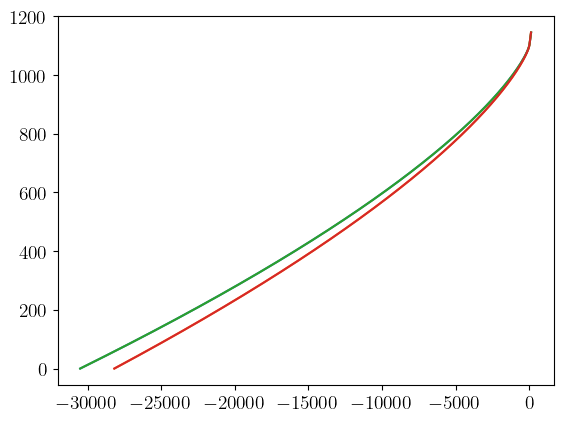

In [125]:
# Agreement between scaled and unscaled phases improves with higher mass ratio

q=15
l=2
m=2

plt.plot(tNR_0PA(q),unwrappedphase_0PA(q,l,m))
plt.plot(tNR_scaled(q),unwrappedphase_scaled(q,l,m))
plt.plot(tNR_0PA(q),unwrappedphaseinterp_0PA(q,l,m)(tNR_0PA(q)))
plt.plot(tNR_scaled(q),unwrappedphaseinterp_scaled(q,l,m)(tNR_scaled(q)))

## BHPTNRSur Frequency

In [16]:
#Use second-order finite difference method to calcualte orbital frequency from accumulated NR GW phase data. 
#Unwrappedphaseinterp is an interpolated cubic spline. No need to interpolate frequency.

function_dict['omegaNR_secondorder_finitedifference_0PA'] = {}

def omegaNR_secondorder_finitediff_0PA(q,l,m,t): 
    
    if (q,l,m,tuple(t)) in function_dict['omegaNR_secondorder_finitedifference_0PA']:
        return function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]
    
    else:
        
        m=2 #Include factor of m to calculate orbital frequency rather than GW frequency, to compare with GSF results.
        omega=np.zeros(len(t))
        for i in range(len(t)):
        
            if t[i]<=t[3]: #Forward finite difference at start of vector
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i+1])-unwrappedphaseinterp_0PA(q,l,m)(t[i]))/(m*(t[i+1]-t[i])) 
        
            elif t[i]>=t[-3]: #Backwards finite difference at end of vector
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i])-unwrappedphaseinterp_0PA(q,l,m)(t[i-1]))/(m*(t[i]-t[i-1]))
        
            else: 
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i+1])-unwrappedphaseinterp_0PA(q,l,m)(t[i-1]))/(m*(t[i+1]-t[i-1]))
                
        function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]=omega
        
        return function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]
    
function_dict['omegaNR_secondorder_finitedifference_scaled'] = {}

def omegaNR_secondorder_finitediff_scaled(q,l,m,t): 
    
    if (q,l,m,tuple(t)) in function_dict['omegaNR_secondorder_finitedifference_scaled']:
        return function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]
    
    else:
        
        m=2 #Include factor of m to calculate orbital frequency rather than GW frequency, to compare with GSF results.
        omega=np.zeros(len(t))        
        for i in range(len(t)):
            
            if t[i]<=t[2]: #Forward finite difference at start of vector
                omega[i]=(unwrappedphaseinterp_scaled(q,l,m)(t[i+1])-unwrappedphaseinterp_scaled(q,l,m)(t[i]))/(m*(t[i+1]-t[i])) 
        
            elif t[i]>=t[-2]: #Backwards finite difference at end of vector
                omega[i]=(unwrappedphaseinterp_scaled(q,l,m)(t[i])-unwrappedphaseinterp_scaled(q,l,m)(t[i-1]))/(m*(t[i]-t[i-1]))
        
            else: 
                omega[i]=omega[i]=(unwrappedphaseinterp_scaled(q,l,m,)(t[i+1])-unwrappedphaseinterp_scaled(q,l,m)(t[i-1]))/(m*(t[i+1]-t[i-1]))
                function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]=omega
        
        return function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]

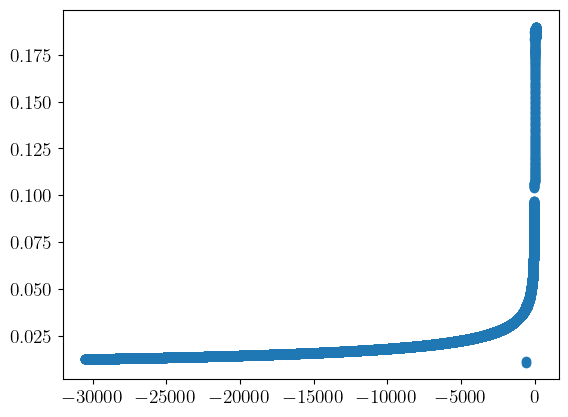

In [17]:
plt.plot(tNR_0PA(q),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q)),'o')

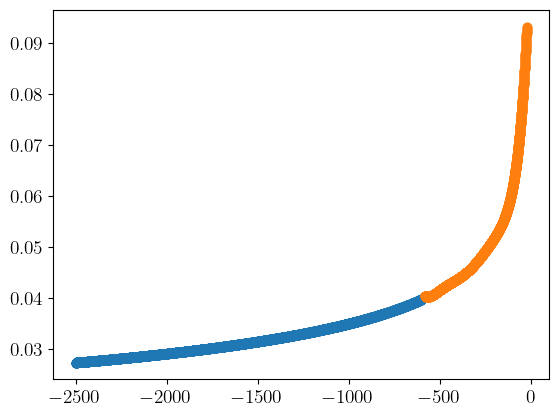

In [18]:
#Cleaning up the noise data, removing spikes that appear from finite differencing
#Need to truncate last few points

plt.figure()

plt.plot(tNR_0PA(q)[140000:149500][:-2],omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q))[140000:149500][:-2],'o')
plt.plot(tNR_0PA(q)[149600:152400][:-2],omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q))[149600:152400][:-2],'o')

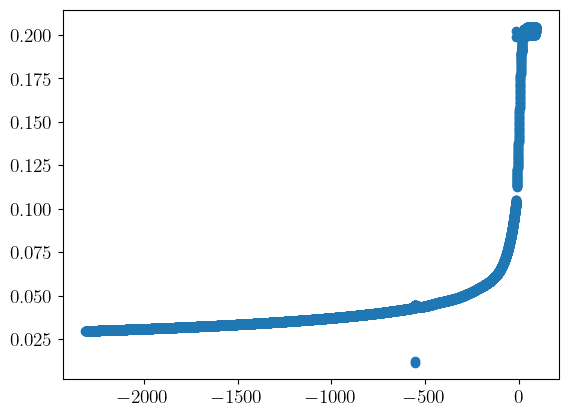

In [19]:
#Full data set takes far too long to run
plt.plot(tNR_scaled(q)[140000:153000],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[140000:153000]),'o')

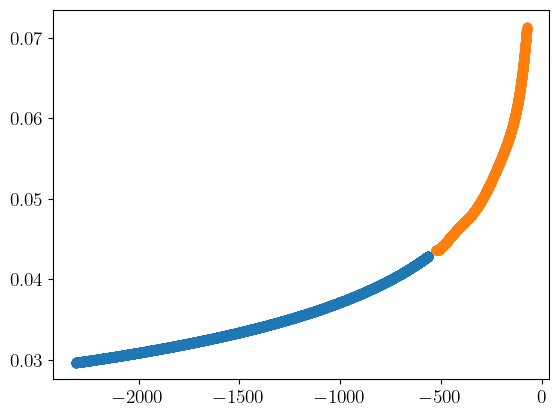

In [20]:
plt.plot(tNR_scaled(q)[140000:149450],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[140000:149450]),'o')
plt.plot(tNR_scaled(q)[149650:152100],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[149650:152100]),'o')

In [21]:
def tNR_0PA_new(q):
    return np.append(tNR_0PA(q)[130000:149500],tNR_0PA(q)[149600:152600]).flatten()

def tNR_scaled_new(q):
    return np.append(tNR_scaled(q)[140000:149450],tNR_scaled(q)[149650:152600]).flatten()

In [22]:
#Need to interpolate so can do finite difference again to calcaulte dOmega/dt
def omegaNR_secondorder_finitediff_0PA_interp(q,l,m,t):
    return interpolate.interp1d(tNR_0PA_new(q),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))(t)

def omegaNR_secondorder_finitediff_scaled_interp(q,l,m,t):
    return interpolate.interp1d(tNR_scaled_new(q),omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))(t)

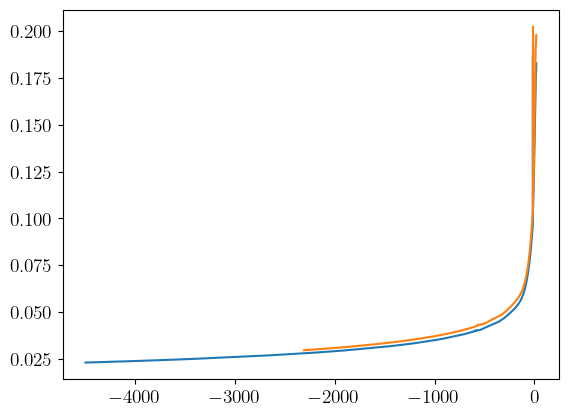

In [23]:
plt.plot(tNR_0PA_new(q),omegaNR_secondorder_finitediff_0PA_interp(q,l,m,tNR_0PA_new(q)))
plt.plot(tNR_scaled_new(q),omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q)))

In [24]:
# Check that frequency is monotonic in a region where we want to match the phases/times.

#q=...
#for i in range(len(tNR_scaled_new(q)[11000:])-1):
#    if omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q)[11000:])[i]>omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q)[11000:])[i+1]:
#        print('NOT MONOTONIC')
#        print(i)
#        print(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q))[i])

## BHPTNRSur Frequency Evolution

In [25]:
# Second-order finite difference
# Applying savgol filter to omega here doesn't seem to work well

# Defining time derivative of orbital frequency

#Function of time
function_dict['domegaNRdt_secondorder_finitediff_0PA'] = {}

def domegaNRdt_secondorder_finitediff_0PA(q,l,m,t):
    
    if (q,l,m,tuple(t)) in function_dict['domegaNRdt_secondorder_finitediff_0PA']:
        return function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]
    
    else:
        
        domegadt_0PA=np.zeros(len(t))
        
        for i in range(len(t)):
            
            #if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.
                       
            if t[i]<=t[2]:
                domegadt_0PA[0]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i]])))/(t[i+1]-t[i])
        
            elif t[i]>=t[-2]:
                domegadt_0PA[-1]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i-1]])))/(t[i]-t[i-1])
        
            else:
                domegadt_0PA[i]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i-1]])))/(t[i+1]-t[i-1])

        function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]=domegadt_0PA 
        
        return function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]

(0.0, 0.00065)

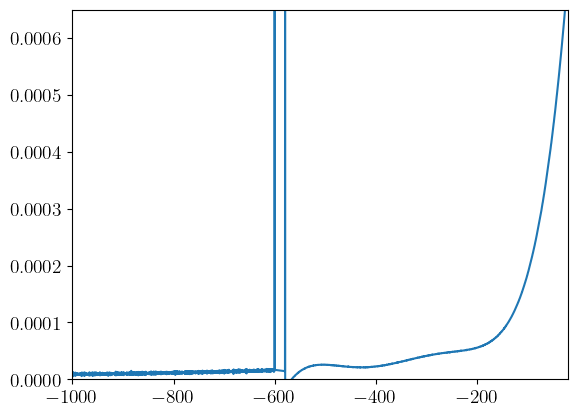

In [26]:
plt.plot(tNR_0PA_new(q),domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))

plt.xlim(-1000,-20)
plt.ylim(0,0.00065)

In [27]:
#second-order finite difference as a function of Omega 

function_dict['domegaNRdt_secondorder_finitediff_Omega_0PA'] = {}

def domegaNRdt_secondorder_finitediff_Omega_0PA(q,l,m): #Function of Omega
    
    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_Omega_0PA']:
        return function_dict['domegaNRdt_secondorder_finitediff_Omega_0PA'][q,l,m]
    
    else:
        
        domegadt_Omega_0PA=interpolate.interp1d(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))
        
        function_dict['domegaNRdt_secondorder_finitediff_Omega_0PA'][q,l,m]=domegadt_Omega_0PA 
        
        return function_dict['domegaNRdt_secondorder_finitediff_Omega_0PA'][q,l,m]

    
#second-order finite difference as a function of DeltaOmega 

function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_0PA'] = {}

def domegaNRdt_secondorder_finitediff_DeltaOmega_0PA(q,l,m):#Function of DeltaOmega
    
    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_0PA']:
        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_0PA'][q,l,m]
    
    else:
        
        domegadt_Omega_0PA=interpolate.interp1d((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))
        
        function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_0PA'][q,l,m]=domegadt_Omega_0PA 
        
        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_0PA'][q,l,m]   

(0.0, 0.0006)

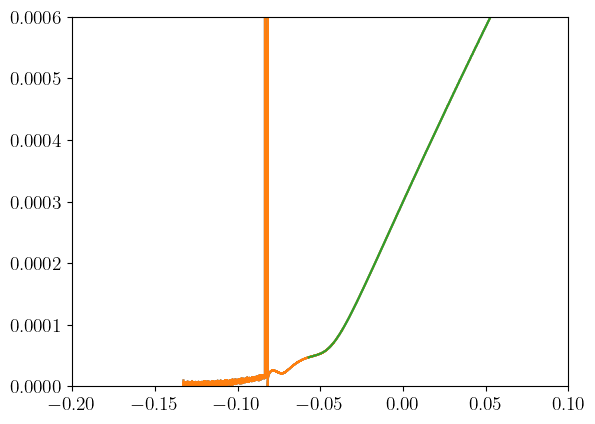

In [29]:
plt.figure()

plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))
plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_DeltaOmega_0PA(q,l,m)((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**(2)))
plt.plot(DeltaOmega_vec(q,eps)[:-200],domegaNRdt_secondorder_finitediff_DeltaOmega_0PA(q,l,m)(DeltaOmega_vec(q,eps))[:-200])

plt.xlim(-0.2,0.1)
plt.ylim(0.000,0.0006)

In [30]:
#second-order finite difference
#Applying savgol filter to omega here doesn't seem to work well

#Defining time derivative of orbital frequency

#Function of time
function_dict['domegaNRdt_secondorder_finitediff_scaled'] = {}

def domegaNRdt_secondorder_finitediff_scaled(q,l,m,t):
    
    if (q,l,m,tuple(t)) in function_dict['domegaNRdt_secondorder_finitediff_scaled']:
        return function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]
    
    else:
        
        delta=0.005
        
        domegadt_scaled=np.zeros(len(t))
        
        for i in range(len(t)):
            
            #if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.
                       
            if t[i]<=t[2]:
                domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i]])))/(t[i+1]-t[i])
        
            elif t[i]>=t[-2]:
                domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i-1]])))/(t[i]-t[i-1])
        
            else:
                domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i-1]])))/(t[i+1]-t[i-1])

        function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]=domegadt_scaled 
        
        return function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]

(0.0, 0.0006)

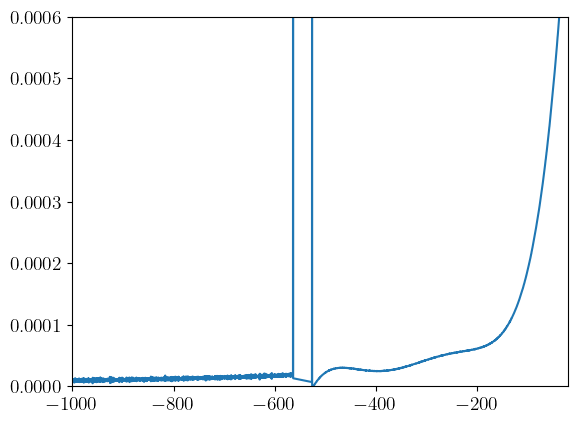

In [31]:
plt.plot(tNR_scaled_new(q)[:-100],domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)[:-100]))

plt.xlim(-1000,-20)
plt.ylim(0,0.0006)

In [32]:
#second-order finite difference as a function of Omega 

function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'] = {}

def domegaNRdt_secondorder_finitediff_Omega_scaled(q,l,m):#Function of Omega
    
    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled']:
        return function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]
    
    else:
        
        domegadt_Omega_scaled=interpolate.interp1d(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
        
        function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]=domegadt_Omega_scaled 
        
        return function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]

    
#second-order finite difference as a function of DeltaOmega 

function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'] = {}

def domegaNRdt_secondorder_finitediff_DeltaOmega_scaled(q,l,m): #Function of DeltaOmega
    
    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled']:
        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]
    
    else:
        
        domegadt_Omega_scaled=interpolate.interp1d((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
        
        function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]=domegadt_Omega_scaled 
        
        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]   

(0.0, 0.0005)

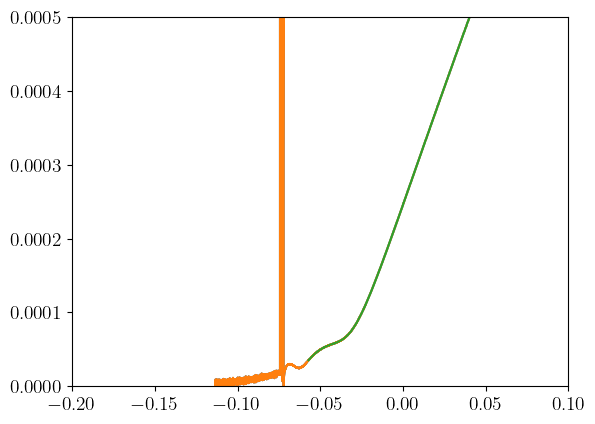

In [33]:
plt.figure()

plt.plot((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
plt.plot((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_DeltaOmega_scaled(q,l,m)((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**(2)))
plt.plot(DeltaOmega_vec(q,eps)[:-300],domegaNRdt_secondorder_finitediff_DeltaOmega_scaled(q,l,m)(DeltaOmega_vec(q,eps)[:-300]))

plt.xlim(-0.2,0.1)
plt.ylim(0.000,0.0005)

(0.0, 0.001)

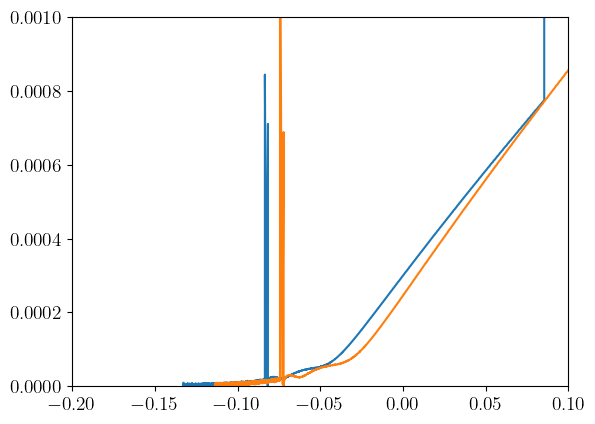

In [34]:
plt.figure()

plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))
#plt.plot(DeltaOmega_vec(qSur(sim))[:-200],domegaNRdt_secondorder_finitediff_DeltaOmega_0PA(sim)(DeltaOmega_vec(qSur(sim))[:-200]))

plt.plot((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
#plt.plot(DeltaOmega_vec(qSur(sim))[:-500],domegaNRdt_secondorder_finitediff_DeltaOmega_scaled(sim)(DeltaOmega_vec(qSur(sim))[:-500]))

plt.xlim(-0.2,0.1)
plt.ylim(0.000,0.001)

## BHPTNRSur Phase as a funciton of $\Omega$

In [35]:
#use coarse time vector, reduces time calculating Omega

function_dict['phase_0PA_Omega'] = {}

def phase_0PA_Omega(q,l,m,Omega):#Call as fOmega) 
    if (q,l,m,tuple(Omega)) in function_dict['phase_0PA_Omega']:
        return function_dict['phase_0PA_Omega'][q,l,m,tuple(Omega)]
    else:
        
        function_dict['phase_0PA_Omega'][q,l,m,tuple(Omega)]=interpolate.interp1d(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),unwrappedphaseinterp_0PA(q,l,m)(tNR_0PA_new(q)))(Omega)
        return function_dict['phase_0PA_Omega'][q,l,m,tuple(Omega)]

function_dict['phase_scaled_Omega'] = {}
def phase_scaled_Omega(q,l,m,Omega):#Call as f(Omega) 
    if (q,l,m,tuple(Omega)) in function_dict['phase_scaled_Omega']:
        return function_dict['phase_scaled_Omega'][q,l,m, tuple(Omega)]
    else:
        
        function_dict['phase_scaled_Omega'][q,l,m,tuple(Omega)]=interpolate.interp1d(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),unwrappedphaseinterp_scaled(q,l,m)(tNR_scaled_new(q)))(Omega)
        return function_dict['phase_scaled_Omega'][q,l,m,tuple(Omega)]

(0.02, 0.1)

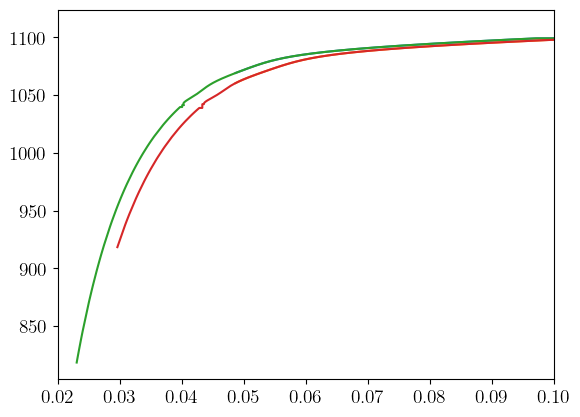

In [36]:
plt.figure()

plt.plot(Omega_vec(q,eps),phase_0PA_Omega(q,l,m,Omega_vec(q,eps)))
plt.plot(Omega_vec(q,eps),phase_scaled_Omega(q,l,m,Omega_vec(q,eps)))

plt.plot(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),phase_0PA_Omega(q,l,m,omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))))
plt.plot(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),phase_scaled_Omega(q,l,m,omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))))

plt.xlim(0.02,0.1)
#plt.ylim(1500,1850)

## BHPTNRSur Amplitudes as a funciton of $\Omega$

In [37]:
#use coarse time vector, reduces time calculating Omega

function_dict['amp_0PA_Omega'] = {}

def amp_0PA_Omega(q,l,m,Omega):#Call as f(Omega) 
    if (q,l,m,tuple(Omega)) in function_dict['amp_0PA_Omega']:
        return function_dict['amp_0PA_Omega'][q,l,m,tuple(Omega)]
    else:
        
        function_dict['amp_0PA_Omega'][q,l,m,tuple(Omega)]=interpolate.interp1d(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),ampNRinterp_0PA(q,l,m,tNR_0PA_new(q)))(Omega)
        return function_dict['amp_0PA_Omega'][q,l,m,tuple(Omega)]

function_dict['amp_scaled_Omega'] = {}
def amp_scaled_Omega(q,l,m,Omega):#Call as f(Omega) 
    if (q,l,m,tuple(Omega)) in function_dict['amp_scaled_Omega']:
        return function_dict['amp_scaled_Omega'][q,l,m, tuple(Omega)]
    else:
        
        function_dict['amp_scaled_Omega'][q,l,m,tuple(Omega)]=interpolate.interp1d(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),ampNRinterp_scaled(q,l,m,tNR_scaled_new(q)))(Omega)
        return function_dict['amp_scaled_Omega'][q,l,m,tuple(Omega)]

(0.025, 0.1)

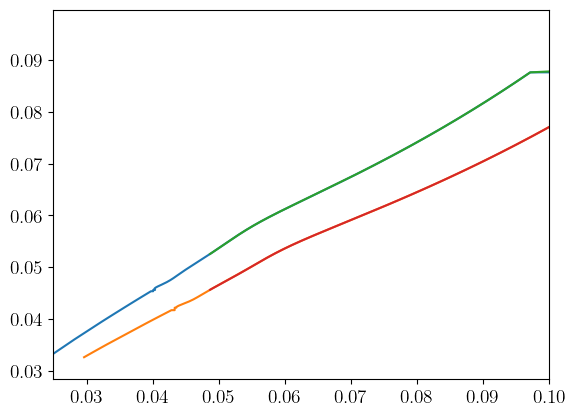

In [38]:
plt.figure()

plt.plot(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),amp_0PA_Omega(q,l,m,omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))))
plt.plot(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),amp_scaled_Omega(q,l,m,omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))))

plt.plot(Omega_vec(q,eps),amp_0PA_Omega(q,l,m,Omega_vec(q,eps)))
plt.plot(Omega_vec(q,eps),amp_scaled_Omega(q,l,m,Omega_vec(q,eps)))

plt.xlim(0.025,0.1)
#plt.ylim(0.008,0.0135)

# SXS Data

In [111]:
#sim = 19, 5, 17, 34 correspond to q = 1, 5, 10, 15
sxsSims=list(["SXS:BBH:0299","SXS:BBH:0298","SXS:BBH:0297","SXS:BBH:0166","SXS:BBH:0296","SXS:BBH:0056","SXS:BBH:0295","SXS:BBH:0167","SXS:BBH:0294","SXS:BBH:0259","SXS:BBH:0301","SXS:BBH:0302","SXS:BBH:0303","SXS:BBH:1132","SXS:BBH:1220","SXS:BBH:0181","SXS:BBH:1108","SXS:BBH:1107","SXS:BBH:0071","SXS:BBH:0180","SXS:BBH:0007","SXS:BBH:1166"])
sxsSims_Box=list(['BBH_SKS_d15_q4.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q4.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q5.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q5.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q6.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q6.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q7.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q7.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q8.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q8.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q9.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q9.50_sA_0_0_0_sB_0_0_0'])
sxsSims_high=list(['q15sur016annex,q15sur019annex'])

In [112]:
#NR data import paths:
def simvar(simpos):
    if simpos<len(sxsSims):
        return sxsSims[simpos][8:12]
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return sxsSims_Box[simpos-len(sxsSims)][12:17]
    elif simpos>=len(sxsSims)+len(sxsSims_Box):
        return sxsSims_high[simpos-len(sxsSims)-len(sxsSims_Box)-1][0:3]

#Determine highest lev to include in file path:
def highestlev(simpos):
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return [x[0] for x in os.walk(f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}")][-1][-1]
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return [x[0] for x in os.walk(f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0")][-1][-1]
    elif simpos==len(sxsSims)+len(sxsSims_Box):
        return [x[0] for x in os.walk(f"{dir_Box}\\{sim}sur016annex")][-1][-1]
    elif simpos==len(sxsSims)+len(sxsSims_Box)+1:
        return [x[0] for x in os.walk(f"{dir_Box}\\{sim}sur019annex")][-1][-1]
            
#Meta data path:
def metapath(simpos):
    lev=highestlev(simpos)
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}\\Lev{lev}\\metadata.txt"
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0\\Lev{lev}\\metadata.txt"
    elif simpos==len(sxsSims)+len(sxsSims_Box):
        return f"{dir_Box}\\{sim}sur016annex\\Lev{lev}\\metadata.txt"
    elif simpos==len(sxsSims)+len(sxsSims_Box)+1:
        return f"{dir_Box}\\{sim}sur019annex\\Lev{lev}\\metadata.txt"

    #Strain data path:
def strainpathNR(simpos):
    lev=highestlev(simpos)
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
    elif simpos==len(sxsSims)+len(sxsSims_Box):
        return f"{dir_Box}\\{sim}sur016annex\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
    elif simpos==len(sxsSims)+len(sxsSims_Box)+1:
        return f"{dir_Box}\\{sim}sur019annex\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
        
#Gives name of simulation based on position in list of sxsSims:
def simname(simpos):
    return metapath(simpos)    

In [113]:
#NR data extraction from files:

function_dict['NR_data'] = {}

#Positions in lists below are chosen to extract relevant data from the rhOverM_Asymptotic_GeometricUnits_CoM.h5 files from the SXS catalogue.
def NRdatextraction(sim,N):
    if (sim,N) in function_dict['NR_data']:
        return function_dict['NR_data'][sim,N]
    else:
        straindat=h5py.File(strainpathNR(sim),'r')
        Ndat=list(straindat.keys())[N-2]
        Yl2m2dat=list(straindat[Ndat].keys())[2]
        h22dat=np.array(straindat[Ndat][Yl2m2dat])
    
        tvec=h22dat[:,0]
    
        ampvec=np.zeros(len(h22dat))
        phasevec=np.zeros(len(h22dat))
        h22vec=np.zeros(len(h22dat))
    
        for i in range(len(h22dat)):
            ampvec[i]=abs(h22dat[i][1]-1j*h22dat[i][2])
            phasevec[i]=cmath.phase(complex(h22dat[i][1],-h22dat[i][2]))
            h22vec[i]=np.real(ampvec[i]*np.e**complex(0,phasevec[i]))
    
        function_dict['NR_data'][sim,N]=np.array([tvec, ampvec, phasevec, h22vec])
        return  function_dict['NR_data'][sim,N]

#Raw NR strain, amplitudes and phase from NR data:
def tNR(sim,N):
    return NRdatextraction(sim,N)[0]

def ampNR(sim,N):
    return NRdatextraction(sim,N)[1]

#GW phase (not orbital phase)
def phaseNR(sim,N):
    return NRdatextraction(sim,N)[2]

def strainNR(sim,N):
    return NRdatextraction(sim,N)[3]

#Interpolated strain, amplitudes and phase from NR data:
def strainNRinterp(sim,N,t):
    return interpolate.interp1d(tNR(sim,N),strainNR(sim,N),kind='cubic')(t)

def ampNRinterp(sim,N,t):
    return interpolate.interp1d(tNR(sim,N),ampNR(sim,N),kind='cubic')(t)

def phaseNRinterp(sim,N,t): #Note that this is not the accumulated phase
    return interpolate.interp1d(tNR(sim,N),phaseNR(sim,N),kind='cubic')(t)

In [114]:
#Extracting metadata from matadata.txt files from SXS catalogue:
#Parameters are given at reference time after junk radiation.

#Find position of a string in a text file:
def stringpos(string,substring):
    position=string.find(substring)
    return position, position+len(substring)

#Positions in lists below are chosen to extract relevant data from the metadata.txt files from the SXS catalogue.
function_dict['NR_metadata'] = {}
def metadata(sim):
    if sim in function_dict['NR_metadata']:
        return function_dict['NR_metadata'][sim]
    else:
        metadatafile=open(metapath(sim),'r')
        content=metadatafile.read()
        
        if sim<len(sxsSims) or 35>=sim>=31:  #For public SXS sims
            posstring=stringpos(content,'Quantities at reference time')
            contentslab=content[posstring[0]::]
    
            posstringt0=stringpos(contentslab,'reference-time = ')
            posstringOmega0=stringpos(contentslab,'reference-orbital-frequency = ')
            posstringm1=stringpos(contentslab,'reference-mass1    = ')
            posstringm2=stringpos(contentslab,'reference-mass2    = ')
            posstringcommonhorizon=stringpos(contentslab,'common-horizon-time')
        
        elif 31>sim>=len(sxsSims): #For SXS sims in Box
            posstring=stringpos(content,'Relaxed quantities')
            contentslab=content[posstring[0]::]
    
            posstringt0=stringpos(contentslab,'relaxed-measurement-time = ')
            posstringOmega0=stringpos(contentslab,'relaxed-orbital-frequency = ')
            posstringm1=stringpos(contentslab,'relaxed-mass1    = ')
            posstringm2=stringpos(contentslab,'relaxed-mass2    = ')
            posstringcommonhorizon=stringpos(contentslab,'common-horizon-time')
            
        #position of spaces, commas etc. are based on formatting of NR metadata.txt files.
        positiont0blank=contentslab[posstringt0[-1]::].find(' ')
        positionOmega0blanknew=posstringOmega0[-1]+contentslab[posstringOmega0[-1]::].find(', ')+2
        positionOmega0blanknew2=positionOmega0blanknew+contentslab[positionOmega0blanknew::].find(', ')+2
        positionOmega0blanknew3=positionOmega0blanknew2+contentslab[positionOmega0blanknew2::].find('#')
        positionm1blank=contentslab[posstringm1[-1]::].find('r')
        positionm2blank=contentslab[posstringm2[-1]::].find(' ')
        positioncommonhorizonblank=contentslab[posstringcommonhorizon[-1]::].find('\n')
        
        function_dict['NR_metadata'][sim]=np.array([float(contentslab[posstringt0[-1]:posstringt0[-1]+positiont0blank-1]),float(contentslab[positionOmega0blanknew2:positionOmega0blanknew3]),float(contentslab[posstringm1[-1]:posstringm1[-1]+positionm1blank-1]),float(contentslab[posstringm2[-1]:posstringm2[-1]+positionm2blank-1]),float(contentslab[posstringcommonhorizon[-1]+4:posstringcommonhorizon[-1]+positioncommonhorizonblank])])
        return function_dict['NR_metadata'][sim]

In [115]:
#Defining metadata functions:

#Start time of simulation after junk radiation:
def t0NR(sim):
    return metadata(sim)[0]

#Initial orbital frequency of simulation after junk radiation:
def Omega0NR(sim):
    return metadata(sim)[1]

#Primary mass:
def m1NR(sim):
    return metadata(sim)[2]

#Secondary mass:
def m2NR(sim):
    return metadata(sim)[3]

#Total mass. #MNR is actually a function of time from horizon data. This will introduce some small error. May want to update this in future.
def MNR(sim): 
    return m1NR(sim)+m2NR(sim)

#Large mass ratio:
def qNR(sim):
    return m1NR(sim)/m2NR(sim)

#Initial orbital radius after junk radiation:
def r0NR(sim):
    return (MNR(sim)*Omega0NR(sim))**(-2/3)

#Horizon time:
def tHorNR(sim):
    return metadata(sim)[-1]

In [116]:
#Define functions for NR data to be shifted to times after junk radiation:

def tNR_afterjunk(sim,N):
    return tNR(sim,N)[position(t0NR(sim),tNR(sim,N))[0]:]

def tNR_afterjunk_tohorizon(sim):
    delta=0.001
    return np.linspace(t0NR(sim)+2*delta,tHorNR(sim),10000)

# SXS Functions

## SXS Phase

In [117]:
#Define accumulated phase starting after junk.

function_dict['NR_phase_unwrapped'] = {}

def unwrappedphase(sim,N): 
    if (sim,N) in function_dict['NR_phase_unwrapped']:
        return function_dict['NR_phase_unwrapped'][sim,N]
    else:
        function_dict['NR_phase_unwrapped'][sim,N]=-np.unwrap(phaseNR(sim,N))
        return function_dict['NR_phase_unwrapped'][sim,N]

    
function_dict['NR_phase_unwrapped_interp'] = {}

def unwrappedphaseinterp(sim,N): #Call as unwrappedphaseinterp(sim,N)(t)
    if (sim,N) in function_dict['NR_phase_unwrapped_interp']:
        return function_dict['NR_phase_unwrapped_interp'][sim,N]
    else:
        function_dict['NR_phase_unwrapped_interp'][sim,N]=interpolate.interp1d(tNR(sim,N),unwrappedphase(sim,N),kind='cubic')
        return function_dict['NR_phase_unwrapped_interp'][sim,N]

## SXS Frequency

In [118]:
#Use fourth-order finite difference method to calcualte orbital frequency from accumulated NR GW phase data. 
#Unwrappedphaseinterp is an interpolated cubic spline. No need to interpolate frequency.

function_dict['omegaNR_fourthorder_finitedifference'] = {}

def omegaNR_fourthorder_finitediff(sim,N,t): 
    
    if (sim,N,tuple(t)) in function_dict['omegaNR_fourthorder_finitedifference']:
        return function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]
    
    else:
        
        delta=0.001
        m=2 #Include factor of m to calcualte orbital frequency rather than GW frequency, to compare with GSF results.
        
        omega=np.zeros(len(t))
        
        for i in range(len(t)):
        
            if t[i]<tNR_afterjunk(sim,N)[1]: #Forward finite difference at start of vector
                omega[i]=(unwrappedphaseinterp(sim,N)(t[i]+delta)-unwrappedphaseinterp(sim,N)(t[i]))/(m*delta) 
        
            elif t[i]>tNR_afterjunk(sim,N)[-2]: #Backwards finite difference at end of vector
                omega[i]=(unwrappedphaseinterp(sim,N)(t[i])-unwrappedphaseinterp(sim,N)(t[i]-delta))/(m*delta)
        
            else: 
                 omega[i]=(-unwrappedphaseinterp(sim,N)(t[i]+2*delta)+8*unwrappedphaseinterp(sim,N)(t[i]+delta)-8*unwrappedphaseinterp(sim,N)(t[i]-delta)+unwrappedphaseinterp(sim,N)(t[i]-2*delta))/(12*m*delta)
        
        function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]=omega 
        
        return function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]
    
#Fourth-order finite difference interpolated (function of t) 
function_dict['omegaNR_fourthorder_finitediff_interp_t'] = {}
def omegaNR_fourthorder_finitediff_interp_t(sim,N):#Function of t
    
    if (sim,N) in function_dict['omegaNR_fourthorder_finitediff_interp_t']:
        return function_dict['omegaNR_fourthorder_finitediff_interp_t'][sim,N]
    
    else:
        
        omega=interpolate.interp1d(tNR_afterjunk_tohorizon(sim,N),omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
        
        function_dict['omegaNR_fourthorder_finitediff_interp_t'][sim,N]=omega 
        
        return function_dict['omegaNR_fourthorder_finitediff_interp_t'][sim,N]

    
    
function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'] = {}

def omegaNR_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N):
    if (order, window, omega_min,omega_max,sim,N) in function_dict['omegaNR_fourthorder_finitedifference_savgolfilter']:
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]
    else:
        #omega_min_pos=position(omega_min,omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk(sim,N)))[0]
        #omega_max_pos=position(omega_max,omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk(sim,N)))[0]
        function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]=savgol_filter(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)), window,order, deriv=0, delta=0.01, mode='interp')
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]
    

#Need to interpolate if want to access omegaNR_fourthorder_finitediff_savgolfilter at a specific time t[i], or t[i]+delta. 
#Need to do this to obtain domegadt

function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'] = {}

def omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N):#Call as f(t) where t lies between tNR_afterjunk(sim,N)[omega_min_pos:omega_max_pos]
    if (order, window, omega_min,omega_max,sim,N) in function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp']:
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order,window,omega_min,omega_max,sim,N]
    else:
        #omega_min_pos=position(omega_min,omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk(sim,N)))[0]
        #omega_max_pos=position(omega_max,omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk(sim,N)))[0]
        function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order, window, omega_min,omega_max,sim,N]=interpolate.interp1d(tNR_afterjunk_tohorizon(sim),omegaNR_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N),kind='cubic')
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order, window, omega_min,omega_max,sim,N]

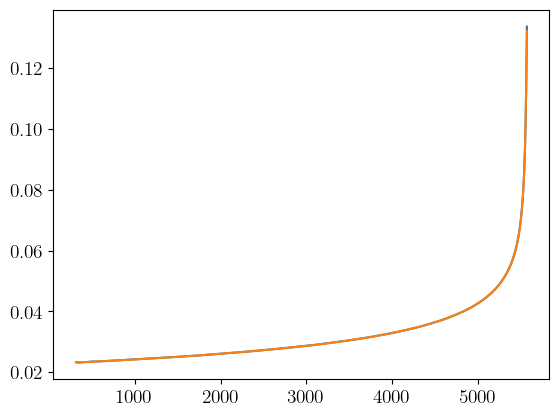

In [119]:
order=4
window=201

sim=34

omega_min=Omega_vec(qNR(sim),nu)[0]
omega_max=Omega_vec(qNR(sim),nu)[-1]

#Which is the smoothest?
plt.plot(tNR_afterjunk_tohorizon(sim),omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))
plt.plot(tNR_afterjunk_tohorizon(sim),omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)))

In [120]:
#Check for duplicates. These cause problems when interpolating later on.
#for sim in range(4):
#    for i in range(len(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))-1):
#        if omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))[i]==omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))[i+1]:
#            print('has dupilate')
#            print(i)

## Aligning SXS and BHPTNRSur phases

In [121]:
order=4
window=201

sim=34

omega_min=Omega_vec(qNR(sim),eps)[0]
omega_max=Omega_vec(qNR(sim),eps)[-1]

print(position(Omegai(),omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))))
print(position(Omegai(),omegaNR_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))))

(9847, 0.06808265216385935)
(11834, 0.06808167575057567)


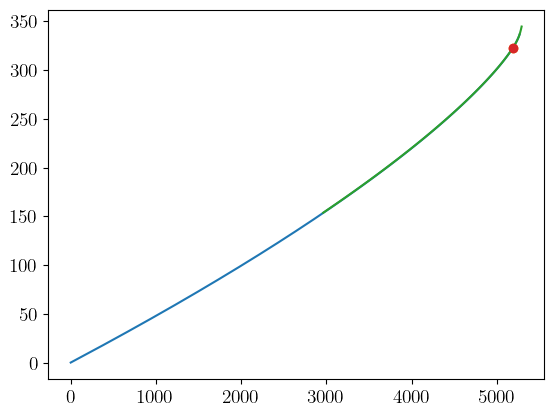

In [135]:
sim=34
plt.plot(tNR_afterjunk_tohorizon(sim)-tNR_afterjunk_tohorizon(sim)[0],unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))-unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))[0])
plt.plot(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0],unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim)[9847])-unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))[0],'o')

plt.plot(tNR_scaled_new(qNR(sim))-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim)))-unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[0])+(unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim)[9847])-unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))[0])-(unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[11834])-unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[0])))
plt.plot(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[11834])-unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[0])+(unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim)[9847])-unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))[0])-(unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[11834])-unwrappedphaseinterp_scaled(qNR(sim),l,m)(tNR_scaled_new(qNR(sim))[0])),'o')

## Aligning SXS and BHPTNRSur frequencies

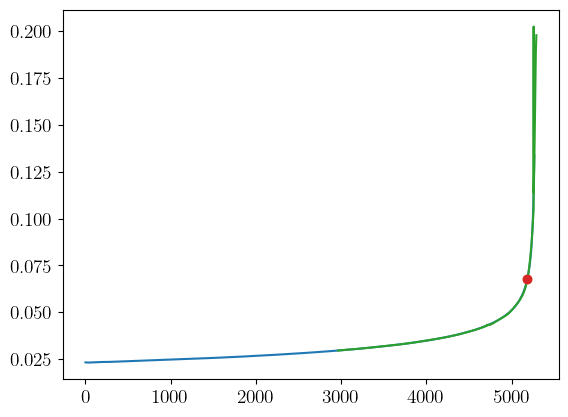

In [51]:
order=6
window=101

sim=34

omega_min=Omega_vec(qNR(sim),eps)[0]
omega_max=Omega_vec(qNR(sim),eps)[-1]

plt.plot(tNR_afterjunk_tohorizon(sim)-tNR_afterjunk_tohorizon(sim)[0],omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)))
plt.plot(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0],Omegai(),'o')

plt.plot(tNR_scaled_new(qNR(sim))-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(qNR(sim))))
plt.plot(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),Omegai(),'o')


## Aligning SXS and BHPTNRSur amplitudes

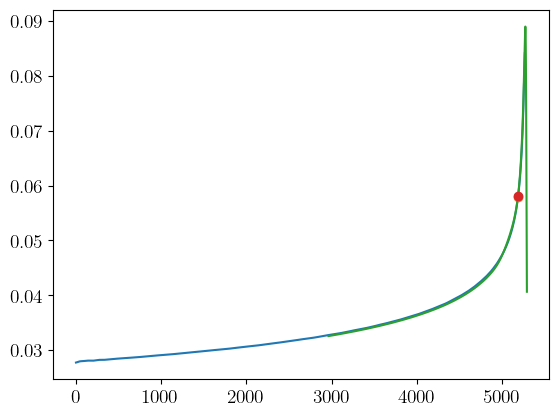

In [52]:
order=6
window=101

sim=34

omega_min=Omega_vec(qNR(sim),eps)[0]
omega_max=Omega_vec(qNR(sim),eps)[-1]

plt.plot(tNR_afterjunk_tohorizon(sim)-tNR_afterjunk_tohorizon(sim)[0],ampNRinterp(sim,N_test,tNR_afterjunk_tohorizon(sim)))
plt.plot(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0],ampNRinterp(sim,N_test,tNR_afterjunk_tohorizon(sim)[9847]),'o')

plt.plot(tNR_scaled_new(qNR(sim))-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),ampNRinterp_scaled(q,l,m,tNR_scaled_new(qNR(sim))))
plt.plot(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),ampNRinterp_scaled(q,l,m,tNR_scaled_new(qNR(sim))[11834]),'o')


## SXS Frequency Evolution

In [53]:
#Fourth-order finite difference
#Applying savgol filter to omega here doesn't seem to work well

#Defining time derivative of orbital frequency

#Function of time
function_dict['domegaNRdt_fourthorder_finitediff'] = {}

def domegaNRdt_fourthorder_finitediff(sim,N,t):
    
    if (sim,N,tuple(t)) in function_dict['domegaNRdt_fourthorder_finitediff']:
        return function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]
    
    else:
        
        delta=0.001
        
        domegadt=np.zeros(len(t))
        
        for i in range(len(t)):
            
            #if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.
                       
            if t[i]<tNR_afterjunk(sim,N)[1]:
                domegadt[0]=(omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+delta]))-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]])))/(delta)
        
            elif t[i]>tNR_afterjunk(sim,N)[-2]:
                domegadt[-1]=(omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]]))-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-delta])))/(delta)
        
            else:
                domegadt[i]=(-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+2*delta]))+8*omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+delta]))-8*omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-delta]))+omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-2*delta])))/(12*delta)

        function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]=domegadt 
        
        return function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]


#Fourth-order finite difference interpolated (function of t) 
function_dict['domegaNRdt_fourthorder_finitediff_interp_t'] = {}
def domegaNRdt_fourthorder_finitediff_interp_t(sim,N):#Function of t
    
    if (sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_interp_t']:
        return function_dict['domegaNRdt_fourthorder_finitediff_interp_t'][sim,N]
    
    else:
        
        domegadt_Omega=interpolate.interp1d(tNR_afterjunk_tohorizon(sim),domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
        
        function_dict['domegaNRdt_fourthorder_finitediff_interp_t'][sim,N]=domegadt_Omega 
        
        return function_dict['domegaNRdt_fourthorder_finitediff_interp_t'][sim,N]

    
#Fourth-order finite difference as a function of Omega 
function_dict['domegaNRdt_fourthorder_finitediff_Omega'] = {}

def domegaNRdt_fourthorder_finitediff_Omega(sim,N):#Function of Omega
    
    if (sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_Omega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_Omega'][sim,N]
    
    else:
        
        domegadt_Omega=interpolate.interp1d(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
        
        function_dict['domegaNRdt_fourthorder_finitediff_Omega'][sim,N]=domegadt_Omega 
        
        return function_dict['domegaNRdt_fourthorder_finitediff_Omega'][sim,N]

    
#Fourth-order finite difference as a function of DeltaOmega 

function_dict['domegaNRdt_fourthorder_finitediff_DeltaOmega'] = {}

def domegaNRdt_fourthorder_finitediff_DeltaOmega(sim,N):#Function of DeltaOmega
    
    if (sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_DeltaOmega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_DeltaOmega'][sim,N]
    
    else:
        
        domegadt_Omega=interpolate.interp1d((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
        
        function_dict['domegaNRdt_fourthorder_finitediff_DeltaOmega'][sim,N]=domegadt_Omega 
        
        return function_dict['domegaNRdt_fourthorder_finitediff_DeltaOmega'][sim,N]   

In [54]:
#Function of time with savgol filter applied to domegadt
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'] = {}

def domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N):
    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]
    else:
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),window,order,deriv=0, delta=0.05, mode='interp')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]
    
#Function of Omega with savgol filter applied to domegadt
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Omega'] = {}

def domegaNRdt_fourthorder_finitediff_savgolfilter_Omega(order,window,omega_min,omega_max,sim,N):
    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Omega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Omega'][order,window,omega_min,omega_max,sim,N]
    else:
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Omega'][order,window,omega_min,omega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff_Omega(sim,N)(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))),window,order,deriv=0, delta=0.05, mode='interp')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Omega'][order,window,omega_min,omega_max,sim,N]
                                                                                                                                    
#Function of DeltaOmega with savgol filter applied to domegadt
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega'] = {}

def domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N):
    if (order,window,deltaomega_min,deltaomega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]
    else:        
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff_DeltaOmega(sim,N)(((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))-Omegai())/sigma(qNR(sim))**2),window,order,deriv=0, delta=0.01, mode='interp')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]                                                                                                                                 

In [55]:
#Function of Omega with savgol filter applied to domegadt interpolated
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega'] = {}

def domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega(order,window,omega_min,omega_max,sim,N):
    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega'][order,window,omega_min,omega_max,sim,N]
    else:
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega'][order,window,omega_min,omega_max,sim,N]=interpolate.interp1d(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff_savgolfilter_Omega(order,window,omega_min,omega_max,sim,N),kind='cubic')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega'][order,window,omega_min,omega_max,sim,N]  

#Function of DeltaOmega with savgol filter applied to domegadt interpolated
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega'] = {}

def domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N):
    if (order,window,deltaomega_min,deltaomega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]
    else:        
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]=interpolate.interp1d((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N),kind='cubic')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega'][order,window,deltaomega_min,deltaomega_max,sim,N]                                                                                                                                 

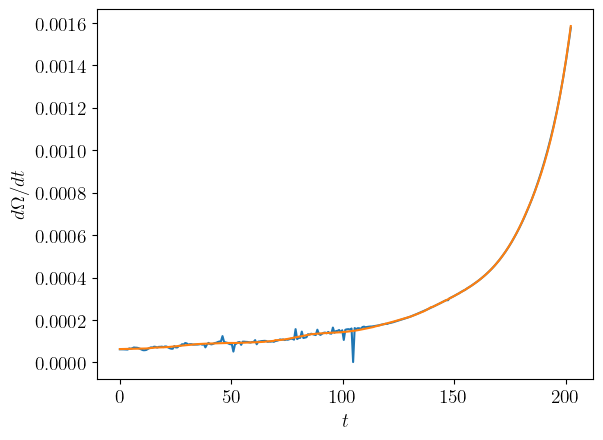

In [56]:
order=6
window=101

for sim in np.array([4]):

    omega_min=Omega_vec(qNR(sim),nu)[0]
    omega_max=Omega_vec(qNR(sim),nu)[-1]
        
    omega_min_pos=position(omega_min,omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))[0]
    omega_max_pos=position(omega_max,omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))[0]

    plt.plot(tNR_afterjunk_tohorizon(sim)[omega_min_pos:omega_max_pos]-tNR_afterjunk_tohorizon(sim)[omega_min_pos],domegaNRdt_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)[omega_min_pos:omega_max_pos]))
    plt.plot(tNR_afterjunk_tohorizon(sim)[omega_min_pos:omega_max_pos]-tNR_afterjunk_tohorizon(sim)[omega_min_pos],domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test)[omega_min_pos:omega_max_pos])
    
    plt.ylabel('$d\Omega/dt$')
    plt.xlabel('$t$')

(0.0, 0.001)

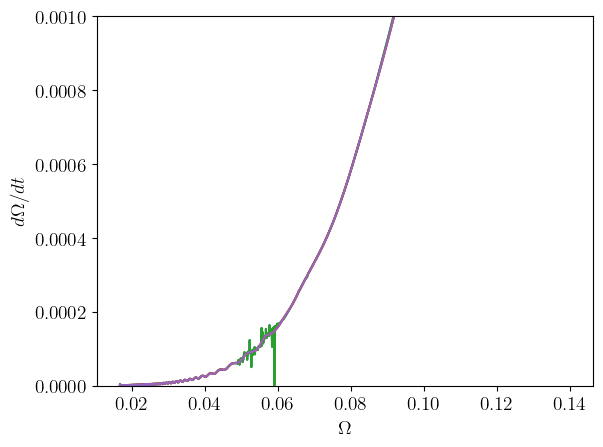

In [57]:
order=6
window=101

for sim in np.array([4]):

    plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))
    plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test))
    
    plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff_Omega(sim,N_test)(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))))
    plt.plot(omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff_savgolfilter_Omega(order,window,omega_min,omega_max,sim,N_test))
    plt.plot(omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))[2:-2],domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Omega(order,window,omega_min,omega_max,sim,N_test)(omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)[2:-2])))

    plt.ylabel('$d\Omega/dt$')
    plt.xlabel('$\Omega$')
    
plt.ylim(0,0.001)

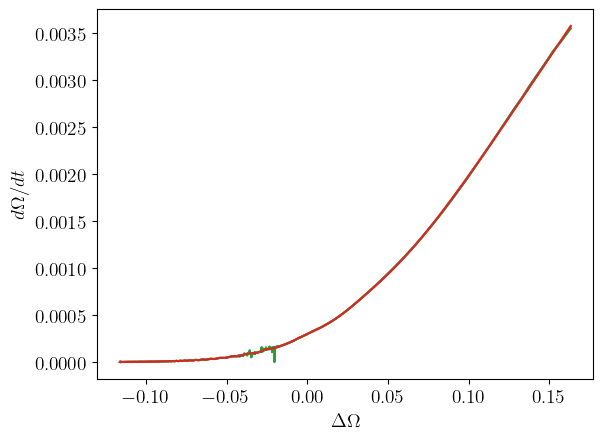

In [58]:
order=6
window=101

for sim in np.array([4]):

    deltaomega_min=DeltaOmega_vec(qNR(sim),nu)[0]
    deltaomega_max=DeltaOmega_vec(qNR(sim),nu)[-1]

    plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)))
    plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test))
    
    plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_DeltaOmega(sim,N_test)((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2))
    plt.plot((omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test))

    plt.ylabel('$d\Omega/dt$')
    plt.xlabel('$\Delta\Omega$')

In [59]:
sim=34
print(position(Omegai(),omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))))
print(domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test)[9847])

print(position(Omegai(),omegaNR_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))))
print(domegaNRdt_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))[11833])

(9847, 0.06806505994954336)
0.00021111095668762151
(11834, 0.06808167575057567)
0.00024558784584098603


Text(0.5, 0, '$t$')

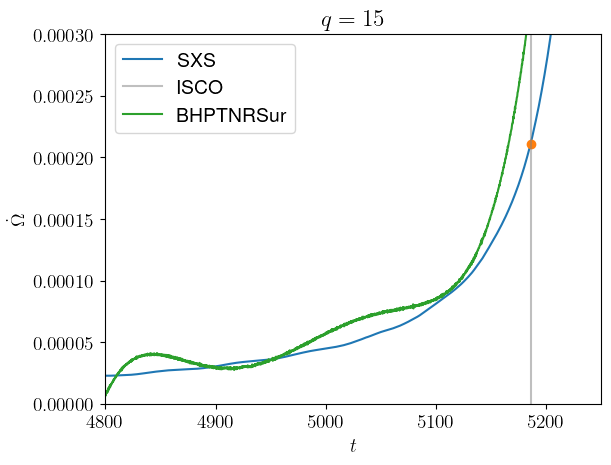

In [60]:
sim=34
plt.plot(tNR_afterjunk_tohorizon(sim)-tNR_afterjunk_tohorizon(sim)[0],domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test),label='SXS')
plt.plot(tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0],domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N_test)[9847],'o')
plt.axvline(x = tNR_afterjunk_tohorizon(sim)[9847]-tNR_afterjunk_tohorizon(sim)[0], color = 'gray',alpha=0.5, label='ISCO')

sim=3
plt.plot(tNR_scaled_new(qNR(sim))[:-2]-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(34)[9847]-tNR_afterjunk_tohorizon(34)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),domegaNRdt_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))[:-2],label='BHPTNRSur')
plt.plot(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]+(tNR_afterjunk_tohorizon(34)[9847]-tNR_afterjunk_tohorizon(34)[0])-(tNR_scaled_new(qNR(sim))[11834]-tNR_scaled_new(qNR(sim))[0]),domegaNRdt_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))[11834],'o')

plt.xlim(4800,5250)
plt.ylim(0,0.0003)

plt.legend()
plt.title('$q = 15$')
plt.ylabel('$\dot{\Omega}$')
plt.xlabel('$t$')

Text(0.5, 0, '$\\Delta\\Omega$')

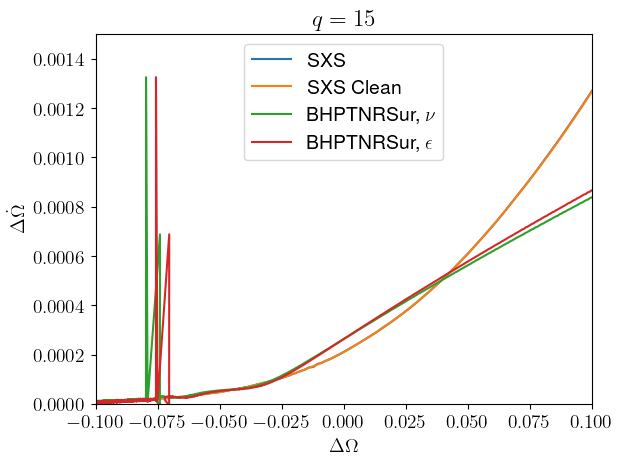

In [61]:
sim=34
plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_DeltaOmega(sim,N_test)((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2), label='SXS')
plt.plot((omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test), label='SXS Clean')

plt.plot((omegaNR_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(sim))[:-2]-Omegai())/sigma(qNR(sim))**2,domegaNRdt_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim)))[:-2],label='BHPTNRSur, $\\nu$')
plt.plot((omegaNR_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(sim))-Omegai())/lam(qNR(sim))**2,domegaNRdt_secondorder_finitediff_scaled(qNR(sim),l,m,tNR_scaled_new(qNR(sim))),label='BHPTNRSur, $\epsilon$')

plt.ylim(0,0.0015)
plt.xlim(-0.1,0.1)

plt.legend()
plt.title('$q = 15$')
plt.ylabel('$\Delta\dot{\Omega}$')
plt.xlabel('$\Delta\Omega$')

## SXS Phase as a fuction of $\Omega$

Text(0.5, 0, '$\\Omega$')

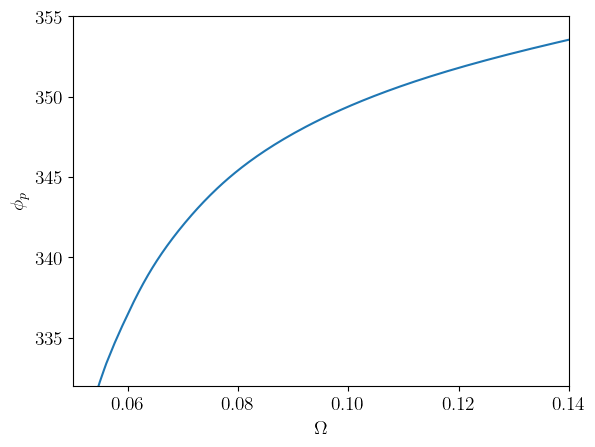

In [62]:
sim=4
plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,(tNR_afterjunk_tohorizon(sim))),unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim)))

plt.ylim(332,355)
plt.xlim(0.05,0.14)

plt.ylabel('$\phi_p$')
plt.xlabel('$\Omega$')

## SXS Amplitudes as a function of $\Omega$

Text(0.5, 0, '$t$')

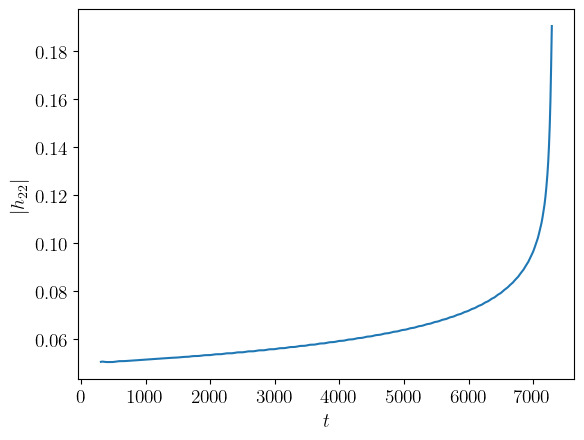

In [63]:
plt.plot(tNR_afterjunk_tohorizon(sim),ampNRinterp(sim,N_test,tNR_afterjunk_tohorizon(sim)))

#plt.ylim(0.03,0.05)
#plt.xlim(300,5000)
plt.ylabel('$|h_{22}|$')
plt.xlabel('$t$')

Text(0.5, 0, '$\\Delta\\Omega$')

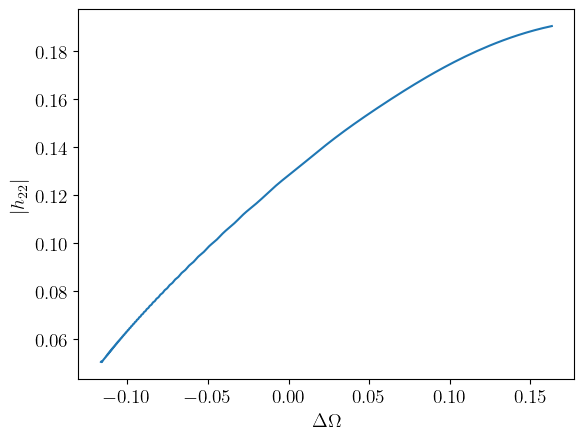

In [64]:
plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,ampNRinterp(sim,N_test,tNR_afterjunk_tohorizon(sim)))

plt.ylabel('$|h_{22}|$')
plt.xlabel('$\Delta\Omega$')

# GSF Data

## Frequency and Phase Evolution during the transition to plunge (transition-only dynamics, not including inspiral motion)

In [65]:
#Values of first order energy flux at infinity and its derivative with respect to the leading order radius for circular orbit of radius at the ISCO. 

flux1i=0.000940339356315095200 #Check if these values are already multiplied by 1/epsilon^2. What are their units?
dflux1idr0=-0.000892028880193301200

#Define t component of self-force at the ISCO:
ft1i=-(3/2)*flux1i #3/4

#Define t component of omega derivative of self-force at the ISCO:
dft1idomega=3*(6**(1/2))*(-flux1i+12*dflux1idr0) #3*((3/2)**(1/2))*(flux1i+12*dflux1idr0) 

In [66]:
#Boundary conditions for X0 and X2 at early times. #See Sec. (7.1.3) of LCD thesis.

#Note that tmin and tmax are not physical times, but the 'times' at which we can solve for X0 and X2 in the transition regime, from the early to late transition to appropriatley capture the desired dynamics.
tmin=-20 
tmax=30
tspan=np.linspace(tmin,tmax,1000+1)

def X0early(t):
    return -23167355502936795986195010/t**51 - 10223331600760441482825/t**46 - 5628415395384607293/t**41 - 3972772364116824/t**36 - 3722335794387/t**31 - 4846966614/t**26 -9346005/t**21 - 29349/t**16 - 177/t**11 - 3/t**6 - 1/t

def X0earlyprime(t):
    return 1181535130649776595295945510/t**52 + 470273253634980308209950/t**47 +230765031210768899013/t**42 + 143019805108205664/t**37 + 115392409625997/t**32 + 126021131964/t**27 + 196266105/t**22 + 469584/t**17 + 1947/t**12 + 18/t**7 + 1/t**2

def X2early(t):
    return -1.24338856914683318262945630044 -123573.898042321183276235978732/t**15 -538.14669953365742657341937005/t**10 -5.7270612249289095272197379651/t**5

def X2earlyprime(t):
    return 1.8536084706348177491435396810*10**6/t**16 + 5381.4669953365742657341937005/t**11 + 28.635306124644547636098689826/t**6

yinit=np.array([X0early(tmin),X0earlyprime(tmin),X2early(tmin),X2earlyprime(tmin)])

In [67]:
#Coupled differential equations for orbital phase and orbital frequency evolution: 
#See Sec. (7.1.3) of LCD thesis for origin of formula below, with: #(y[0]=X0,y[1]=dX0dt,y[2]=X2,y[3]=dX2dt). 
#X0 and X2 (y[0] and y[2]) are rescaled leading and next-to leading-order forcing terms during the inspiral, which determine the frequency evolution.
#The second and final element of the array below are expressions for X0'' and X2''.
# Note also that it would be ideal to have the frequency evolution independent of mass ratio, and in turn of the NR simulation to which we are comparing. However, the difference will be negligible.

def transitionfrequencyevolution0PA(t,y): #Should be independent of Mass ratio
    M=1
    return np.array([y[1],1/y[0]**2-(y[1]**2)/y[0]+t/y[0],y[3],((3/2)**(1/10))*dft1idomega*(((ft1i**2)/M**3)**(1/5))*t/(2*(2**(1/2))*ft1i*y[0]**2)+2*(3**(3/5))*(((-ft1i*M)**(2/5))*t/(y[0]**2))+11*((3)**(3/5))*((-ft1i*M)**(2/5))*(t**2)/(2*y[0])-2*y[2]/y[0]**3-t*y[2]/y[0]**2+13*(3**(3/5))*((-ft1i*M)**(2/5))*y[1]+y[2]*(y[1]**2)/y[0]**2-2*y[1]*y[3]/y[0]])


In [68]:
#Solving for X0 and X2.

function_dict['transition_frequency']={}

function_dict['transition_frequency']['t']={}
function_dict['transition_frequency']['X0']={}
function_dict['transition_frequency']['X2']={}

def transitionfrequencysolution0PA():
 
    if len(function_dict['transition_frequency']['t']) != 0 :
        return function_dict['transition_frequency']['t'], function_dict['transition_frequency']['X0'], function_dict['transition_frequency']['X2']
    
    else:
        sol= solve_ivp(lambda t, y: transitionfrequencyevolution0PA(t,y),[tmin, tmax], yinit, method='RK45', rtol = 5e-14)
        function_dict['transition_frequency']['t']=sol.t
        function_dict['transition_frequency']['X0']=sol.y[0]
        function_dict['transition_frequency']['X2']=sol.y[2]
        return function_dict['transition_frequency']['t'], function_dict['transition_frequency']['X0'], function_dict['transition_frequency']['X2']
    
function_dict['X0']={}
def X0(t):
    if (tuple(t)) in function_dict['X0']:
        return function_dict['X0'][tuple(t)]
    else:
        function_dict['X0'][tuple(t)] = interpolate.interp1d(transitionfrequencysolution0PA()[0],transitionfrequencysolution0PA()[1])(t)
        return function_dict['X0'][tuple(t)]
    
function_dict['X2']={}
def X2(t):
    if (tuple(t)) in function_dict['X2']:
        return function_dict['X2'][tuple(t)]
    else:
        function_dict['X2'][tuple(t)]=interpolate.interp1d(transitionfrequencysolution0PA()[0],transitionfrequencysolution0PA()[2])(t)
        return function_dict['X2'][tuple(t)]

In [69]:
#Using solution to X0 and X2 to construct forcing terms: FdeltaOmega0 and FdeltaOmega2. 
#See Sec. (7.1.3) of LCD thesis for origin of formulae below.
#Note that DeltaOmega = (Omega - Omegai)/lam(sim).

#Alpha and beta are rescaling factors to convert X0 and X2 to FdeltaOmega0 and FdeltaOmega2.
def alpha_fun(): #alpha is for plot transparency. Use alpha_fun instead
    M=1
    return -ft1i/(2*24*9*((6)**(1/2))*M**3) #Check units for ft1i. Make sure there is consistency throughout regarding factors of M.

def beta():
    M=1
    return 1/(9*((6)**(1/2))*M)

#Forcing terms as a function of Omega
def FdeltaOmega0_Omega(Omega,q,massratiotype):#This now has an expansion in lambda?
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X0((alpha_fun()**(-2/5))*(beta()**(3/5))*(Omega-Omegai())/(massratiotype(q)**(2/5)))

def FdeltaOmega2_Omega(Omega,q,massratiotype):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X2(((alpha_fun())**(-2/5))*(beta()**(3/5))*(Omega-Omegai())/(massratiotype(q)**(2/5)))

#Forcing terms as a function of DeltaOmega
def FdeltaOmega0_DeltaOmega(DeltaOmega):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X0(((alpha_fun())**(-2/5))*(beta()**(3/5))*DeltaOmega)

def FdeltaOmega2_DeltaOmega(DeltaOmega):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X2(((alpha_fun())**(-2/5))*(beta()**(3/5))*DeltaOmega)

In [70]:
# Transition only, Omega
def comp0_transonly_Omega(Omega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_Omega(Omega,q,massratiotype)

def comp2_transonly_Omega(Omega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_Omega(Omega,q,massratiotype)+(massratiotype(q)**(3/5))*FdeltaOmega2_Omega(Omega,q,massratiotype)

def comp0_transonly_Omega_interp(Omega,q,massratiotype):
    return interpolate.interp1d(Omega_vec(q,massratiotype),comp0_transonly_Omega(Omega_vec(q,massratiotype),q,massratiotype),kind='cubic')(Omega) 

def comp2_transonly_Omega_interp(Omega,q,massratiotype):
    return interpolate.interp1d(Omega_vec(q,massratiotype),comp2_transonly_Omega(Omega_vec(q,massratiotype),q,massratiotype),kind='cubic')(Omega)

In [71]:
# Transition only, DeltaOmega
def comp0_transonly_DeltaOmega(DeltaOmega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_DeltaOmega(DeltaOmega)

def comp2_transonly_DeltaOmega(DeltaOmega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_DeltaOmega(DeltaOmega)+(massratiotype(q)**(3/5))*FdeltaOmega2_DeltaOmega(DeltaOmega)

def comp0_transonly_DeltaOmega_interp(DeltaOmega,q,massratiotype):
    return interpolate.interp1d(DeltaOmega_vec(q,massratiotype),comp0_transonly_DeltaOmega(DeltaOmega_vec(q,massratiotype),q,massratiotype),kind='cubic')(DeltaOmega) 

def comp2_transonly_DeltaOmega_interp(DeltaOmega,q,massratiotype):
    return interpolate.interp1d(DeltaOmega_vec(q,massratiotype),comp2_transonly_DeltaOmega(DeltaOmega_vec(q,massratiotype),q,massratiotype),kind='cubic')(DeltaOmega)

# Comparing GSF, SXS and BHPTNRSur frequency evolution

Text(0.5, 0, '$\\Delta\\Omega$')

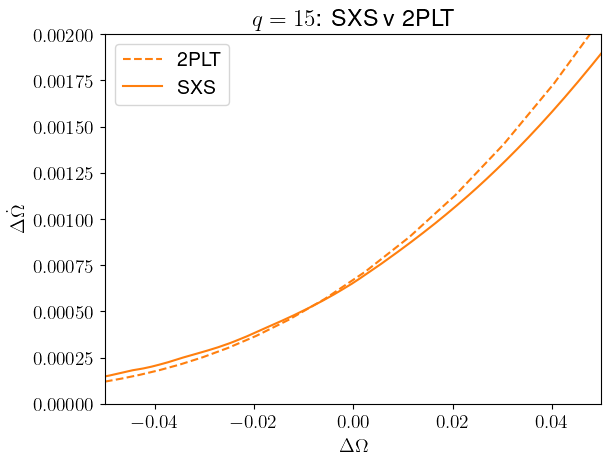

In [72]:
sim=34
plt.plot(DeltaOmega_vec(qNR(sim),nu),comp2_transonly_DeltaOmega(DeltaOmega_vec(qNR(sim),nu),qNR(sim),nu), color='C1', ls='--', label='2PLT')
#plt.plot((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,(1/sigma(qNR(sim))**2)*domegaNRdt_fourthorder_finitediff_DeltaOmega(sim,N_test)((omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2))
plt.plot((omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,(1/sigma(qNR(sim))**2)*domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test),color='C1', label='SXS')

#sim=3
#plt.plot((omegaNR_secondorder_finitediff_scaled(sim,tNR_scaled_new(sim))[:-2]-Omegai())/sigma(qSur(sim))**2,domegaNRdt_secondorder_finitediff_scaled(sim,tNR_scaled_new(sim))[:-2],label='BHPTNRSur')
#plt.plot((omegaNR_secondorder_finitediff_scaled(sim,tNR_scaled_new(sim))-Omegai())/lam(qSur(sim))**2,(1/lam(qSur(sim))**2)*domegaNRdt_secondorder_finitediff_scaled(sim,tNR_scaled_new(sim)),color='C1',ls='dotted',label='BHPTNRSur scaled')

plt.ylim(0,0.002)
plt.xlim(-0.05,0.05)

plt.legend()
plt.title('$q = 15$: SXS v 2PLT')
plt.ylabel('$\Delta\dot{\Omega}$')
plt.xlabel('$\Delta\Omega$')

Text(0.5, 0, '$\\Delta\\Omega$')

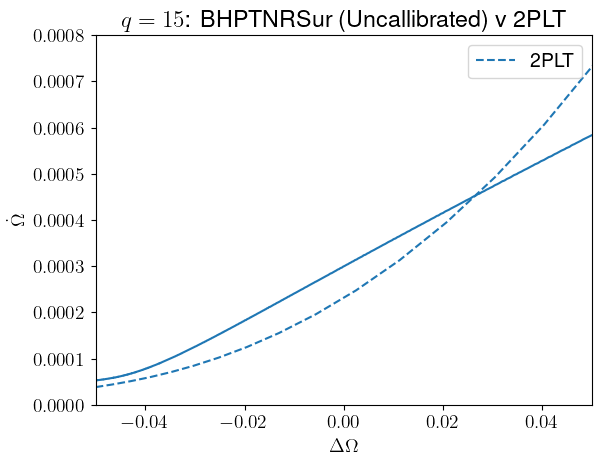

In [73]:
q=15
sim=34
plt.plot(DeltaOmega_vec(qNR(sim),eps),(lam(q)**2)*comp2_transonly_DeltaOmega(DeltaOmega_vec(qNR(sim),eps),qNR(sim),eps), color='C0', ls='--', label='2PLT')

#plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))[:-2]-Omegai())/sigma(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))[:-2],label='BHPTNRSur')
plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),color='C0')

#plt.plot((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))[:-2]-Omegai())/sigma(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))[:-2],label='BHPTNRSur')
#plt.plot((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))

plt.ylim(0,0.0008)
plt.xlim(-0.05,0.05)

plt.legend()
plt.title('$q = 15$: BHPTNRSur (Uncallibrated) v 2PLT')
plt.ylabel('$\dot{\Omega}$')
plt.xlabel('$\Delta\Omega$')

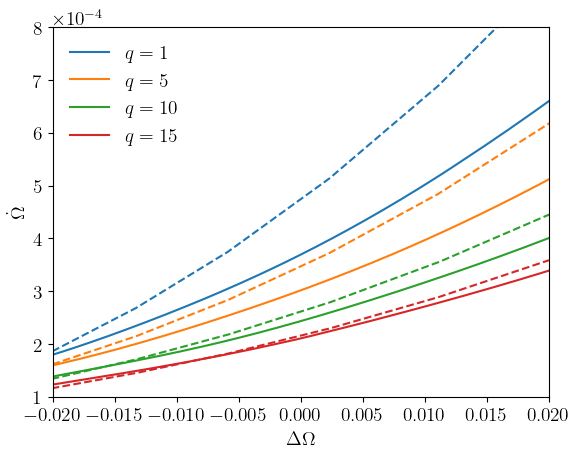

In [258]:
deltaomega_min=-0.05
deltaomega_max=0.25

for sim in np.array([19,24,17,34]):
  
    if sim==19:
        order=6
        window=101 
        colour='C0'
    elif sim==24:
        order=6
        window=101
        colour='C1'
    elif sim==17:
        order=6
        window=101
        colour='C2'
    elif sim==34:
        order=6
        window=101
        colour='C3'
        
    plt.plot(DeltaOmega_vec(qNR(sim),nu),(sigma(qNR(sim))**2)*comp2_transonly_DeltaOmega(DeltaOmega_vec(qNR(sim),nu),qNR(sim),nu), color=colour, ls='--')
    plt.plot((omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim))-Omegai())/sigma(qNR(sim))**2,domegaNRdt_fourthorder_finitediff_savgolfilter_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test),color=colour, label='$q=%.0f$'%qNR(sim))

plt.xlim(-0.02,0.02)
plt.ylim(0.0001,0.0008)

plt.ylabel('$\dot{\Omega}$')
plt.xlabel('$\Delta\Omega$')
plt.legend(loc='upper left', frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('Figures/dOmegadt_DeltaOmega_SXSsimsvGSF_nearISCO.png',bbox_inches='tight')

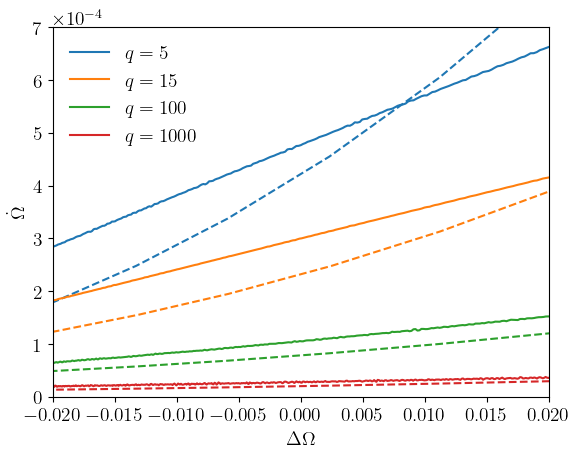

In [257]:
for q in np.array([5,15,100,1000]):
  
    if q==5:
        colour='C0'
    #elif q==10:
    #    colour='C1'
    elif q==15:
        colour='C1'
    elif q==100:
        colour='C2'
    elif q==1000:
        colour='C3'
        
    plt.plot(DeltaOmega_vec(q,eps),(lam(q)**2)*comp2_transonly_DeltaOmega(DeltaOmega_vec(q,eps),q,eps), color=colour, ls='--')
    plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),color=colour, label='$q=%.0f$'%q)

plt.xlim(-0.02,0.02)
plt.ylim(0.000,0.0007)

plt.ylabel('$\dot{\Omega}$')
plt.xlabel('$\Delta\Omega$')
plt.legend(loc='upper left', frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('Figures/dOmegadt_DeltaOmega_BHPTNRSur_UncalibratedvGSF_nearISCO.png',bbox_inches='tight')

# Residual of frequency evolution between SXS and 2PLT

Text(0.5, 0, '$\\nu$')

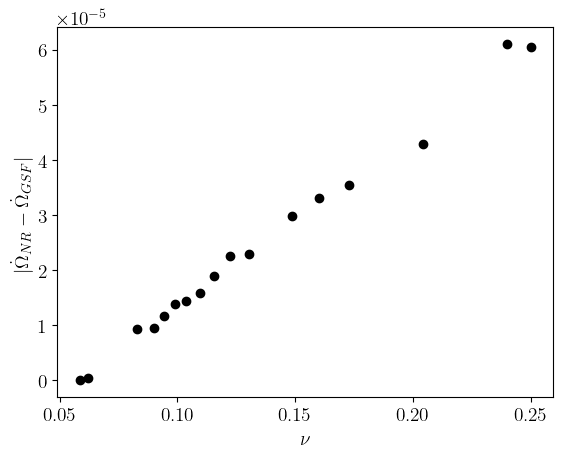

In [77]:
deltaomega_min=-0.05
deltaomega_max=0.25
order=6
window=101
fixed_deltaomega=-0.008

for sim in np.array([19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34]):
    plt.plot(nu(qNR(sim)),(sigma(qNR(sim))**2)*comp2_transonly_DeltaOmega(np.array([fixed_deltaomega]),qNR(sim),nu)-domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test)(fixed_deltaomega),'o', color='black')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel('$|\dot{\Omega}_{NR}-\dot{\Omega}_{GSF}|$')
plt.xlabel('$\\nu$')

In [78]:
def polynomial3_const(x,a,o): 
    return o+a*x**(3/5)
def polynomial4_const(x,a,o): 
    return o+a*x**(4/5)
def polynomial5_const(x,a,o):
    return o+a*x**(5/5)
def polynomial6_const(x,a,o):
    return o+a*x**(6/5)
def polynomial7_const(x,a,o):
    return o+a*x**(7/5)
def polynomial8_const(x,a,o):
    return o+a*x**(8/5)

def polynomial3(x,a): 
    return a*x**(3/5)
def polynomial4(x,a): 
    return a*x**(4/5)
def polynomial5(x,a):
    return a*x**(5/5)
def polynomial6(x,a):
    return a*x**(6/5)
def polynomial7(x,a):
    return a*x**(7/5)
def polynomial8(x,a):
    return a*x**(8/5)


def polynomial3p4(x,a,b):
    return a*x**(3/5)+b*x**(4/5)
def polynomial4p5(x,a,b):
    return a*x**(4/5)+b*x**(5/5)
def polynomial5p6(x,a,b):
    return a*x**(5/5)+b*x**(6/5)
def polynomial6p7(x,a,b):
    return a*x**(6/5)+b*x**(7/5)
def polynomial7p8(x,a,b):
    return a*x**(7/5)+b*x**(8/5)

def polynomial3p4p5(x,a,b,c):
    return a*x**(3/5)+b*x**(4/5)+c*x**(5/5)
def polynomial4p5p6(x,a,b,c):
    return a*x**(4/5)+b*x**(5/5)+c*x**(6/5)
def polynomial5p6p7(x,a,b,c):
    return a*x**(5/5)+b*x**(6/5)+c*x**(7/5)
def polynomial6p7p8(x,a,b,c):
    return a*x**(6/5)+b*x**(7/5)+c*x**(8/5)
def polynomial7p8p9(x,a,b,c):
    return a*x**(7/5)+b*x**(8/5)+c*x**(9/5)

def polynomial_free_2params(x,a,p1):
    return a*x**(p1)

fixed_deltaomega=-0.008

resdOmegadt_vec=[None]*17
dOmegadtNR_vec=[None]*17
dOmegadt0PLT_vec=[None]*17
dOmegadt2PLT_vec=[None]*17

for sim in np.array([19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34]):#np.array([0, 2, 13, 9, 14, 5, 15, 23, 25, 17, 10, 30, 32, 34, 35]): #0,2,13, 21, 9, 14, 5, 15, 23, 25, 17, 12, 16, 10, 30, 21, 32, 34, 35
    resdOmegadt_vec[[19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34].index(sim)]=(sigma(qNR(sim))**2)*comp2_transonly_DeltaOmega(np.array([fixed_deltaomega]),qNR(sim),nu)[0]-domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega(order,window,deltaomega_min,deltaomega_max,sim,N_test)(fixed_deltaomega)
    dOmegadtNR_vec[[19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34].index(sim)]=domegaNRdt_fourthorder_finitediff_savgolfilter_interp_DeltaOmega(order, window, deltaomega_min, deltaomega_max,sim,N_test)(fixed_deltaomega)
    dOmegadt0PLT_vec[[19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34].index(sim)]=(sigma(qNR(sim))**2)*comp0_transonly_DeltaOmega(np.array([fixed_deltaomega]),qNR(sim),nu)[0]
    dOmegadt2PLT_vec[[19, 20, 9, 8, 14, 23, 25, 15, 27, 28, 29, 30, 31, 32, 17, 35, 34].index(sim)]=(sigma(qNR(sim))**2)*comp2_transonly_DeltaOmega(np.array([fixed_deltaomega]),qNR(sim),nu)[0]

nu_vec=np.linspace(0,0.25,17)
nu_vec_true=np.array([nu(qNR(19)),nu(qNR(20)), nu(qNR(9)), nu(qNR(8)), nu(qNR(14)), nu(qNR(23)), nu(qNR(25)), nu(qNR(15)), nu(qNR(27)), nu(qNR(28)), nu(qNR(29)), nu(qNR(30)),nu(qNR(31)), nu(qNR(32)), nu(qNR(17)), nu(qNR(35)), nu(qNR(34))])

resdOmegadt_interp=interpolate.interp1d(nu_vec_true,np.array(resdOmegadt_vec))
dOmegadtNR_interp=interpolate.interp1d(nu_vec_true,dOmegadtNR_vec)
dOmegadt0PLT_interp=interpolate.interp1d(nu_vec_true,dOmegadt0PLT_vec)
dOmegadt2PLT_interp=interpolate.interp1d(nu_vec_true,dOmegadt2PLT_vec)

#nu_vec_dense=np.linspace(0.0586,0.25,100)

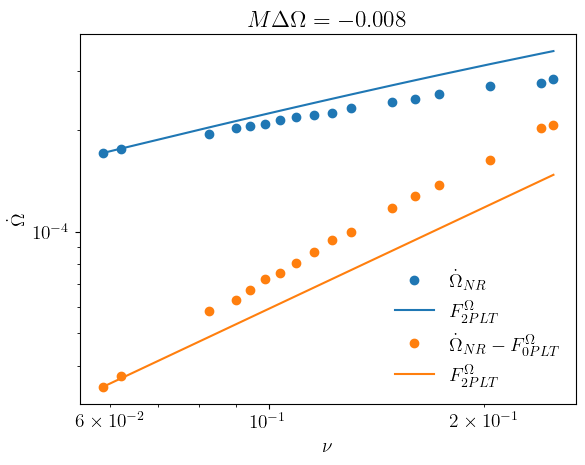

In [237]:
plt.loglog(nu_vec_true,dOmegadtNR_interp(nu_vec_true),'o',label='$\dot{\Omega}_{NR}$',color='C0')
plt.loglog(nu_vec_true,dOmegadt2PLT_interp(nu_vec_true),label='$F^{\Omega}_{2PLT}$',color='C0')

plt.loglog(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),'o',label='$\dot{\Omega}_{NR}-F^{\Omega}_{0PLT}$',color='C1')
plt.loglog(nu_vec_true,np.abs(dOmegadt2PLT_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),label='$F^{\Omega}_{2PLT}$',color='C1')
#plt.loglog(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt2PLT_interp(nu_vec_true)),'o',label='NR-2PLT',color='C2')

plt.legend(frameon=False)
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\Omega}$')
plt.title('$M\Delta\Omega=-0.008$')

plt.savefig('Figures/dOmegadt_scaling_SXSvGSF.png',bbox_inches='tight')

Text(0.5, 1.0, '$M\\Delta\\Omega=-0.008$')

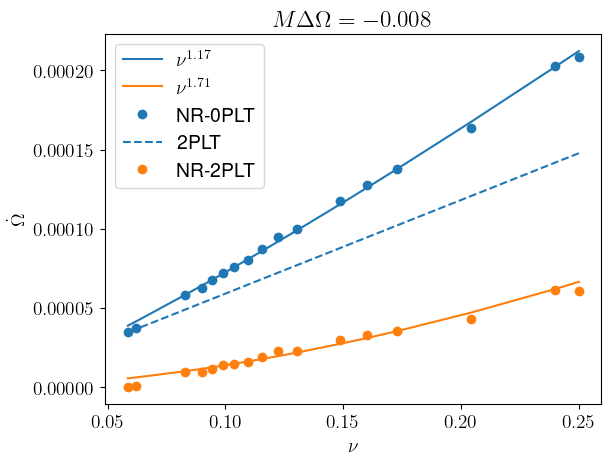

In [80]:
nu_vec_small=np.linspace(0.0586,0.2,100)

coeffsNRM0PLT=curve_fit(polynomial_free_2params, nu_vec_small, np.abs(dOmegadtNR_interp(nu_vec_small)-dOmegadt0PLT_interp(nu_vec_small)), maxfev=5000)[0]
coeffsNRM0PLTM2PLT=curve_fit(polynomial_free_2params, nu_vec_small, np.abs(dOmegadtNR_interp(nu_vec_small)-dOmegadt2PLT_interp(nu_vec_small)), maxfev=5000)[0]


plt.plot(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRM0PLT),label='$\\nu^{%.2f}$'%coeffsNRM0PLT[1],color='C0')
plt.plot(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRM0PLTM2PLT),label='$\\nu^{%.2f}$'%coeffsNRM0PLTM2PLT[1],color='C1')

plt.plot(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),'o',label='NR-0PLT',color='C0')
plt.plot(nu_vec_true,np.abs(dOmegadt2PLT_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),label='2PLT',color='C0',ls='dashed')
plt.plot(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt2PLT_interp(nu_vec_true)),'o',label='NR-2PLT',color='C1')

plt.legend()
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\Omega}$')
plt.title('$M\Delta\Omega=-0.008$')

Text(0.5, 1.0, '$M\\Delta\\Omega=-0.008$')

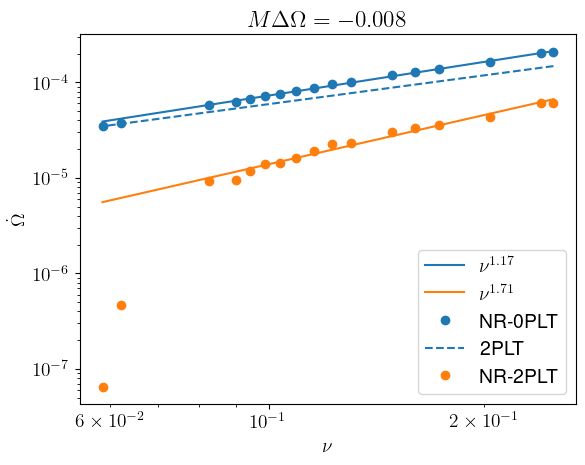

In [81]:
plt.loglog(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRM0PLT),label='$\\nu^{%.2f}$'%coeffsNRM0PLT[1],color='C0')
plt.loglog(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRM0PLTM2PLT),label='$\\nu^{%.2f}$'%coeffsNRM0PLTM2PLT[1],color='C1')

plt.loglog(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),'o',label='NR-0PLT',color='C0')
plt.loglog(nu_vec_true,np.abs(dOmegadt2PLT_interp(nu_vec_true)-dOmegadt0PLT_interp(nu_vec_true)),label='2PLT',color='C0',ls='dashed')
plt.loglog(nu_vec_true,np.abs(dOmegadtNR_interp(nu_vec_true)-dOmegadt2PLT_interp(nu_vec_true)),'o',label='NR-2PLT',color='C1')

plt.legend()
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\Omega}$')
plt.title('$M\Delta\Omega=-0.008$')

## Integrating transition-only dynamics

In [ ]:
#NOTE:

#Even if use DeltaOmegafinal or Omegafinal as critical value, the integrator still goes beyond this value. 
#Need to cut off integration earlier than this.
#The frequency at which the integration should be cut off varies with mass ratio.
#Need to cut off frequency much earlier for q=1000
#Use Omega_cutoff and DeltaOmega_cutoff as variable instead

In [82]:
#DeltaOmega

function_dict['omega_evol']={}
function_dict['omega_evol']['comp0evol_DeltaOmega']={}

def comp0evol_DeltaOmega(t,y,q,massratiotype):
    
    if (tuple(y),q,massratiotype) in function_dict['omega_evol']['comp0evol_DeltaOmega']:
        return function_dict['omega_evol']['comp0evol_DeltaOmega'][tuple(y),q,massratiotype]
    
    else:
        function_dict['omega_evol']['comp0evol_DeltaOmega'][tuple(y),q,massratiotype]=np.array([comp0_transonly_DeltaOmega_interp(y[0],q,massratiotype),(massratiotype(q)**(2/5))*y[0]+Omegai()])
        return function_dict['omega_evol']['comp0evol_DeltaOmega'][tuple(y),q,massratiotype]

    
function_dict['omega_evol']['comp0sol_DeltaOmega']={}

def comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cuttoff):
    
    M=1
    if (q,massratiotype) in function_dict['omega_evol']['comp0sol_DeltaOmega']:
        return function_dict['omega_evol']['comp0sol_DeltaOmega'][q,massratiotype]
    
    else:
        
        def DeltaOmegacritical(t,y):   
            return y[0]-DeltaOmega_cuttoff #Value must be less than 0.2, or change upper limit of DeltaOmega_vec

        DeltaOmegacritical.terminal=True
        function_dict['omega_evol']['comp0sol_DeltaOmega'][q,massratiotype]=solve_ivp(lambda t, y: comp0evol_DeltaOmega(t,y,q,massratiotype),[0,100000],[DeltaOmegainit(q,massratiotype),0],method='LSODA', events=DeltaOmegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['comp0sol_DeltaOmega'][q,massratiotype]


function_dict['omega_evol']['comp2evol_DeltaOmega']={}

def comp2evol_DeltaOmega(t,y,q,massratiotype):
    
    if (tuple(y),q,massratiotype) in function_dict['omega_evol']['comp2evol_DeltaOmega']:
        return function_dict['omega_evol']['comp2evol_DeltaOmega'][tuple(y),q,massratiotype]
    
    else:
        function_dict['omega_evol']['comp2evol_DeltaOmega'][tuple(y),q,massratiotype]=np.array([comp2_transonly_DeltaOmega_interp(y[0],q,massratiotype),(massratiotype(q)**(2/5))*y[0]+Omegai()]) #remove powers
        return function_dict['omega_evol']['comp2evol_DeltaOmega'][tuple(y),q,massratiotype]

    
function_dict['omega_evol']['comp2sol_DeltaOmega']={}

def comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cuttoff):
    
    if (q,massratiotype) in function_dict['omega_evol']['comp2sol_DeltaOmega']:
        return function_dict['omega_evol']['comp2sol_DeltaOmega'][q,massratiotype]
    else:
        
        def DeltaOmegacritical(t,y):   
            return y[0]-DeltaOmega_cuttoff 
        
        DeltaOmegacritical.terminal=True
        function_dict['omega_evol']['comp2sol_DeltaOmega'][q,massratiotype]=solve_ivp(lambda t, y: comp2evol_DeltaOmega(t,y,q,massratiotype),[0,100000],[DeltaOmegainit(q,massratiotype),0],method='LSODA', events=DeltaOmegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['comp2sol_DeltaOmega'][q,massratiotype]

In [83]:
#Omega

function_dict['omega_evol']['comp0evol_Omega']={}

def comp0evol_Omega(t,y,q,massratiotype):
    
    if (tuple(y),q,massratiotype) in function_dict['omega_evol']['comp0evol_Omega']:
        return function_dict['omega_evol']['comp0evol_Omega'][tuple(y),q,massratiotype]
    
    else:
        function_dict['omega_evol']['comp0evol_Omega'][tuple(y),q,massratiotype]=np.array([comp0_transonly_Omega_interp(np.array([y[0]]),q,massratiotype)[0],y[0]])
        return function_dict['omega_evol']['comp0evol_Omega'][tuple(y),q,massratiotype]

    
function_dict['omega_evol']['comp0sol_Omega']={}

def comp0sol_Omega(q,massratiotype,Omega_cutoff):
    
    if (q,massratiotype) in function_dict['omega_evol']['comp0sol_Omega']:
        return function_dict['omega_evol']['comp0sol_Omega'][q,massratiotype]
    
    else:
        
        def Omegacritical(t,y):   
            return y[0]-Omega_cutoff

        Omegacritical.terminal=True
        function_dict['omega_evol']['comp0sol_Omega'][q,massratiotype]=solve_ivp(lambda t, y: comp0evol_Omega(t,y,q,massratiotype),[0,100000],[Omegainit(),0],method='LSODA', events=Omegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['comp0sol_Omega'][q,massratiotype]


function_dict['omega_evol']['comp2evol_Omega']={}

def comp2evol_Omega(t,y,q,massratiotype):
    
    if (tuple(y),q,massratiotype) in function_dict['omega_evol']['comp2evol_Omega']:
        return function_dict['omega_evol']['comp2evol_Omega'][tuple(y),q,massratiotype]
    
    else:
        function_dict['omega_evol']['comp2evol_Omega'][tuple(y),q,massratiotype]=np.array([comp2_transonly_Omega_interp(np.array([y[0]]),q,massratiotype)[0],y[0]])
        return function_dict['omega_evol']['comp2evol_Omega'][tuple(y),q,massratiotype]

    
function_dict['omega_evol']['comp2sol_Omega']={}

def comp2sol_Omega(q,massratiotype,Omega_cutoff):
    
    M=1
    if (q,massratiotype) in function_dict['omega_evol']['comp2sol_Omega']:
        return function_dict['omega_evol']['comp2sol_Omega'][q,massratiotype]
    else:
        
        def Omegacritical(t,y):   
            return y[0]-Omega_cutoff
        Omegacritical.terminal=True
        function_dict['omega_evol']['comp2sol_Omega'][q,massratiotype]=solve_ivp(lambda t, y: comp2evol_Omega(t,y,q,massratiotype),[0,100000],[Omegainit(),0],method='LSODA', events=Omegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['comp2sol_Omega'][q,massratiotype]

### 0PLT-2PLT Phase

In [84]:
#DeltaOmega
#Omega0PA and Phase0PA must be linearly interpolated, for some reason cubic doesn't work.

def tcomp0_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):
    return comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t

function_dict['Omega_GSF']={}
function_dict['Omega_GSF']['comp0_DeltaOmega']={}

def DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff):#Call as Omegacomp0(q)(t)
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['Omega_GSF']['comp0_DeltaOmega']:
        return function_dict['Omega_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else: 
        function_dict['Omega_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t,comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[0],kind='cubic')
        return function_dict['Omega_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]

function_dict['Phase_GSF']={}    
function_dict['Phase_GSF']['comp0_DeltaOmega']={}

def Phasecomp0_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):#Call as Phasecomp0(q)(t)
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['Phase_GSF']['comp0_DeltaOmega']:
        return function_dict['Phase_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else: 
        function_dict['Phase_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t,comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[1],kind='cubic')
        return function_dict['Phase_GSF']['comp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]

    
def tcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):
    return comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t

function_dict['Omega_GSF']['comp2_DeltaOmega']={}

def DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff):#Call as Omegacomp2(q)(t)
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['Omega_GSF']['comp2_DeltaOmega']:
        return function_dict['Omega_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else: 
        function_dict['Omega_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t,comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[0],kind='cubic')
        return function_dict['Omega_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]

function_dict['Phase_GSF']['comp2_DeltaOmega']={}

def Phasecomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):#Call as Phasecomp2_DeltaOmega(q)(t)
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['Phase_GSF']['comp2_DeltaOmega']:
        return function_dict['Phase_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else: 
        function_dict['Phase_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t,comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[1],kind='cubic')
        return function_dict['Phase_GSF']['comp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]

In [85]:
#Omega
#Omega0PA and Phase0PA must be linearly interpolated, for some reason cubic doesn't work.

def tcomp0_Omega(q,massratiotype,Omega_cutoff):
    return comp0sol_Omega(q,massratiotype,Omega_cutoff).t

function_dict['Omega_GSF']['comp0_Omega']={}

def Omegacomp0(q,massratiotype,Omega_cutoff):#Call as Omegacomp0(q)(t)
    if (q,massratiotype,Omega_cutoff) in function_dict['Omega_GSF']['comp0_Omega']:
        return function_dict['Omega_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]
    else: 
        function_dict['Omega_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]=interpolate.interp1d(comp0sol_Omega(q,massratiotype,Omega_cutoff).t,comp0sol_Omega(q,massratiotype,Omega_cutoff).y[0],kind='cubic')
        return function_dict['Omega_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]

function_dict['Phase_GSF']['comp0_Omega']={}

def Phasecomp0_Omega(q,massratiotype,Omega_cutoff):#Call as Phasecomp0(q)(t)
    if (q,massratiotype,Omega_cutoff) in function_dict['Phase_GSF']['comp0_Omega']:
        return function_dict['Phase_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]
    else: 
        function_dict['Phase_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]=interpolate.interp1d(comp0sol_Omega(q,massratiotype,Omega_cutoff).t,comp0sol_Omega(q,massratiotype,Omega_cutoff).y[1],kind='cubic')
        return function_dict['Phase_GSF']['comp0_Omega'][q,massratiotype,Omega_cutoff]

    
def tcomp2_Omega(q,massratiotype,Omega_cutoff):
    return comp2sol_Omega(q,massratiotype,Omega_cutoff).t

function_dict['Omega_GSF']['comp2_Omega']={}

def Omegacomp2(q,massratiotype,Omega_cutoff):#Call as Omegacomp2(q)(t)
    if (q,massratiotype,Omega_cutoff) in function_dict['Omega_GSF']['comp2_Omega']:
        return function_dict['Omega_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]
    else: 
        function_dict['Omega_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]=interpolate.interp1d(comp2sol_Omega(q,massratiotype,Omega_cutoff).t,comp2sol_Omega(q,massratiotype,Omega_cutoff).y[0],kind='cubic')
        return function_dict['Omega_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]

function_dict['Phase_GSF']['comp2_Omega']={}

def Phasecomp2_Omega(q,massratiotype,Omega_cutoff):#Call as Phasecomp2(q)(t)
    if (q,massratiotype,Omega_cutoff) in function_dict['Phase_GSF']['comp2_Omega']:
        return function_dict['Phase_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]
    else: 
        function_dict['Phase_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]=interpolate.interp1d(comp2sol_Omega(q,massratiotype,Omega_cutoff).t,comp2sol_Omega(q,massratiotype,Omega_cutoff).y[1],kind='cubic')
        return function_dict['Phase_GSF']['comp2_Omega'][q,massratiotype,Omega_cutoff]

### Matching SXS and GSF phases

In [189]:
def Omegaipos_phaseNR_Omega(sim,N): #approximate position of Omegai in unwrapped frequency vector
    return position(Omegai(),omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))[0] #omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)))

def tmatchguesstrans_phaseNR_Omega(sim,N): #estimate of time at which Omegainit occurs in NR data
    return tNR_afterjunk_tohorizon(sim)[Omegaipos_phaseNR_Omega(sim,N)]

def frequencymatchtransition_phaseNR_Omega(t): #Includes all times, junk radiation
    N=2
    m=2
    return omegaNR_fourthorder_finitediff(sim,N,np.array([t]))-Omegai()

def tmatchtransition_phaseNR_Omega(sim,N,a,b,tol): #recommend tol = 1e-8, a = 10, b = 0. Guess will be greater than actual value due to the way previous functions are defined
    
    if frequencymatchtransition_phaseNR_Omega(tmatchguesstrans_phaseNR_Omega(sim,N))-(omegaNR_fourthorder_finitediff(sim,N,np.array([tmatchguesstrans_phaseNR_Omega(sim,N)]))-Omegai())==0: #Bracket biscetion method doesn't work if guess solution is exact
        return tmatchguesstrans_phaseNR_Omega(sim,N)
    
    else:
        return my_bisection(frequencymatchtransition_phaseNR_Omega,tmatchguesstrans_phaseNR_Omega(sim,N)+a,tmatchguesstrans_phaseNR_Omega(sim,N)-b,tol)

In [190]:
print(Omegai())
print(omegaNR_fourthorder_finitediff(sim,N_test,np.array([tmatchtransition_phaseNR_Omega(sim,N_test,5,5,5e-14)]))[0])

0.06804138174397717
0.06806490640798302


In [191]:
#def Omegainitpos(sim,N): #approximate position of Omegainit in unwrapped frequency vector
#    return position(Omegai(),omegaNR_fourthorder_finitediff(sim,N,tNRclean(sim)))[0]

#def tmatchguesstrans(sim,N): #estimate of time at which Omegainit occurs in NR data
#    return tNRclean(sim)[Omegainitpos(sim,N)]

#def frequencymatchtransition(t): #Includes all times, junk radiation
#    N=2
#    m=2
#    return omegaNR_fourthorder_finitediff(sim,N,np.array([t]))-Omegai()

#def tmatchtransition(sim,N,a,b,tol): #recommend tol = 1e-8, a = 10, b = 0. Guess will be greater than actual value due to the way previous functions are defined
    
#    if frequencymatchtransition(tmatchguesstrans(sim,N))-(omegaNR_fourthorder_finitediff(sim,N,np.array([tmatchguesstrans(sim,N)]))-Omegai())==0: #Bracket biscetion method doesn't work if guess solution is exact
#        return tmatchguesstrans(sim,N)
    
#    else:
#        return my_bisection(frequencymatchtransition,tmatchguesstrans(sim,N)+a,tmatchguesstrans(sim,N)-b,tol)

In [192]:
def tISCOguesscomp0_Omega(q,massratiotype,Omega_cutoff): #Guess which time the ISCO occurs in comp0 sol
    return comp0sol_Omega(q,massratiotype,Omega_cutoff).t[position(Omegai(), comp0sol_Omega(q,massratiotype,Omega_cutoff).y[0])[0]]

function_dict['times']={}
function_dict['times']['tISCOcomp0_Omega']={}

def tISCOcomp0_Omega(q,massratiotype,Omega_cutoff): #Exact time which ISCO occurs in comp0 sol
    if (q,massratiotype,Omega_cutoff) in function_dict['times']['tISCOcomp0_Omega']:
        return function_dict['times']['tISCOcomp0_Omega'][q,massratiotype,Omega_cutoff]
    else:
        def Omegaapproxerrcomp0(t):
            return Omegacomp0(q,massratiotype,Omega_cutoff)(t)-Omegai()
        function_dict['times']['tISCOcomp0_Omega'][q,massratiotype,Omega_cutoff]=optimize.newton(Omegaapproxerrcomp0,tISCOguesscomp0_Omega(q,massratiotype,Omega_cutoff),tol=5e-14) #uses guess root
        return function_dict['times']['tISCOcomp0_Omega'][q,massratiotype,Omega_cutoff]
    
    
def tISCOguesscomp2_Omega(q,massratiotype,Omega_cutoff): #Guess which time the ISCO occurs in comp0 sol
    return comp2sol_Omega(q,massratiotype,Omega_cutoff).t[position(Omegai(), comp2sol_Omega(q,massratiotype,Omega_cutoff).y[0])[0]]

function_dict['times']['tISCOcomp2_Omega']={}

def tISCOcomp2_Omega(q,massratiotype,Omega_cutoff): #Exact time which ISCO occurs in comp2 sol
    if (q,massratiotype,Omega_cutoff) in function_dict['times']['tISCOcomp2_Omega']:
        return function_dict['times']['tISCOcomp2_Omega'][q,massratiotype,Omega_cutoff]
    else:
        def Omegaapproxerrcomp2(t):
            return Omegacomp2(q,massratiotype,Omega_cutoff)(t)-Omegai()
        function_dict['times']['tISCOcomp2_Omega'][q,massratiotype,Omega_cutoff]=optimize.newton(Omegaapproxerrcomp2,tISCOguesscomp2_Omega(q,massratiotype,Omega_cutoff),tol=5e-10) #uses guess root
        return function_dict['times']['tISCOcomp2_Omega'][q,massratiotype,Omega_cutoff]

In [193]:
def tISCOguesscomp0_DeltaOmega(q,massratiotype,DeltaOmega_cutoff): #Guess which time the ISCO occurs in comp0 sol
    return comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t[position(0, comp0sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[0])[0]]

function_dict['times']['tISCOcomp0_DeltaOmega']={}

def tISCOcomp0_DeltaOmega(q,massratiotype,DeltaOmega_cutoff): #Exact time which ISCO occurs in comp0 sol
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['times']['tISCOcomp0_DeltaOmega']:
        return function_dict['times']['tISCOcomp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else:
        def Omegaapproxerrcomp0(t):
            return DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t)
        function_dict['times']['tISCOcomp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=optimize.newton(Omegaapproxerrcomp0,tISCOguesscomp0_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),tol=5e-14) #uses guess root
        return function_dict['times']['tISCOcomp0_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    
def tISCOguesscomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff): #Guess which time the ISCO occurs in comp0 sol
    return comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).t[position(0, comp2sol_DeltaOmega(q,massratiotype,DeltaOmega_cutoff).y[0])[0]]

function_dict['times']['tISCOcomp2_DeltaOmega']={}

def tISCOcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff): #Exact time which ISCO occurs in comp2 sol
    if (q,massratiotype,DeltaOmega_cutoff) in function_dict['times']['tISCOcomp2_DeltaOmega']:
        return function_dict['times']['tISCOcomp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]
    else:
        def Omegaapproxerrcomp2(t):
            return DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t)
        function_dict['times']['tISCOcomp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]=optimize.newton(Omegaapproxerrcomp2,tISCOguesscomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),tol=5e-10) #uses guess root
        return function_dict['times']['tISCOcomp2_DeltaOmega'][q,massratiotype,DeltaOmega_cutoff]

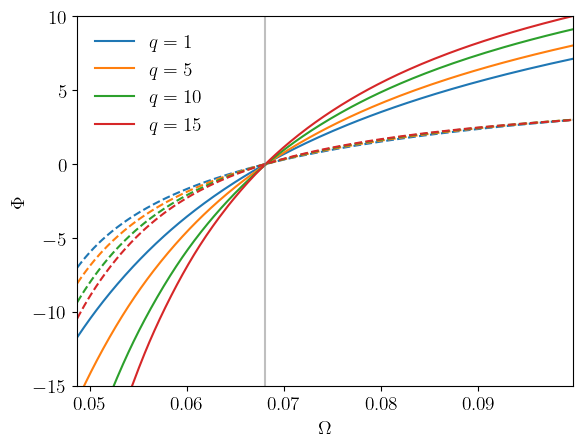

In [238]:
m=2
massratiotype=nu
Omega_cutoff=Omegafinal()-0.005

for sim in np.array([19, 24, 17, 34]):
    
    if sim==19:
        colour='C0'
    elif sim==24:
        colour='C1'
    elif sim==17:
        colour='C2'
    elif sim==34:
        colour='C3'
    
    #plt.plot((nuNR(sim)**(2/5))*DeltaOmegacomp2(sim)(tcomp2_DeltaOmega(sim))+Omegai(),m*Phasecomp2_DeltaOmega(sim)(tcomp2_DeltaOmega(sim))-m*Phasecomp2_DeltaOmega(sim)(tISCOcomp2_DeltaOmega(sim)),ls='--',color='black')
    #plt.plot(Omegacomp2(qNR(sim))(tcomp2_Omega(qNR(sim))),m*Phasecomp2_Omega(qNR(sim))(tcomp2_Omega(qNR(sim))))
    
    plt.plot(Omegacomp2(qNR(sim),massratiotype,Omega_cutoff)(tcomp2_Omega(qNR(sim),massratiotype,Omega_cutoff)),m*Phasecomp2_Omega(qNR(sim),massratiotype,Omega_cutoff)(tcomp2_Omega(qNR(sim),massratiotype,Omega_cutoff))-m*Phasecomp2_Omega(qNR(sim),massratiotype,Omega_cutoff)(tISCOcomp2_Omega(qNR(sim),massratiotype,Omega_cutoff)),ls='--',color=colour)
    plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)),unwrappedphaseinterp(sim,N_test)(tNR_afterjunk_tohorizon(sim))-unwrappedphaseinterp(sim,N_test)(tmatchtransition_phaseNR_Omega(sim,N_test,5,5,5e-14)),label='$q=%.0f$'%qNR(sim),color=colour)
      
plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)

#plt.xlim(0.065,0.07)
plt.ylim(-15,10)
plt.xlim(Omegacomp2(qNR(19),massratiotype,Omega_cutoff)(tcomp2_Omega(qNR(19),massratiotype,Omega_cutoff))[0],Omegacomp2(qNR(19),massratiotype,Omega_cutoff)(tcomp2_Omega(qNR(19),massratiotype,Omega_cutoff))[-1])
    
plt.legend(frameon=False)
plt.ylabel('$\Phi$')
plt.xlabel('$\Omega$')

plt.savefig('Figures/Phase_Omega_SXSsimsvGSF.png',bbox_inches='tight')

In [196]:
def Omegaipos_phaseNR_0PA_Omega(q,l,m): #approximate position of Omegai in unwrapped frequency vector
    return position(Omegai(),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))[0] #omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N_test)(tNR_afterjunk_tohorizon(sim)))

def tmatchguesstrans_phaseNR_0PA_Omega(q,l,m): #estimate of time at which Omegainit occurs in NR data
    return tNR_0PA_new(q)[Omegaipos_phaseNR_0PA_Omega(q,l,m)]

def tmatchtransition_phaseNR_0PA_Omega(q,l,m,a,b,tol): #recommend tol = 1e-8, a = 10, b = 0. Guess will be greater than actual value due to the way previous functions are defined
    
    def frequencymatchtransition_phaseNR_0PA_Omega(t): #Includes all times, junk radiation
        return omegaNR_secondorder_finitediff_0PA(q,l,m,t)-Omegai()

    if frequencymatchtransition_phaseNR_0PA_Omega(tNR_0PA_new(q))[Omegaipos_phaseNR_0PA_Omega(q,l,m)]-(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))[Omegaipos_phaseNR_0PA_Omega(q,l,m)]-Omegai())==0: #Bracket biscetion method doesn't work if guess solution is exact
        return tmatchguesstrans_phaseNR_0PA_Omega(q,l,m)
    
    else:
        return my_bisection(frequencymatchtransition_phaseNR_0PA_Omega,tmatchguesstrans_phaseNR_0PA_Omega(q,l,m)+a,tmatchguesstrans_phaseNR_0PA_Omega(q,l,m)-b,tol)

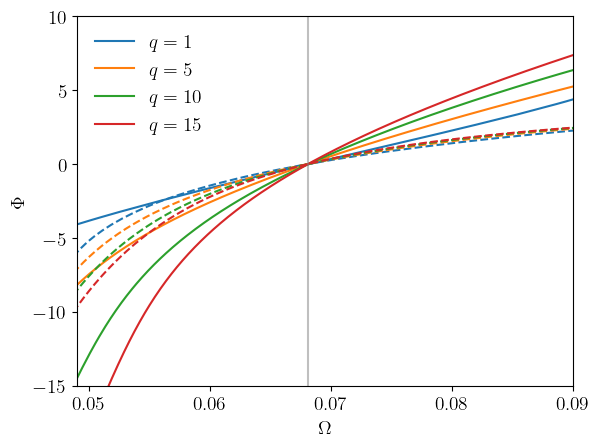

In [239]:
#Difficult to match phases using frequencies with BHPTNRSur as dynamics are not correct

m=2
massratiotype=eps
Omega_cutoff=Omegafinal()-0.005

for q in np.array([1, 5, 10, 15]):
    
    if q==1:
        colour='C0'
    elif q==5:
        colour='C1'
    elif q==10:
        colour='C2'
    elif q==15:
        colour='C3'
    elif q==100:
        colour='C4'
    elif q==1000:
        colour='C5'
    
    #plt.plot((nuNR(sim)**(2/5))*DeltaOmegacomp2(sim)(tcomp2_DeltaOmega(sim))+Omegai(),m*Phasecomp2_DeltaOmega(sim)(tcomp2_DeltaOmega(sim))-m*Phasecomp2_DeltaOmega(sim)(tISCOcomp2_DeltaOmega(sim)),ls='--',color='black')
    #plt.plot(Omegacomp2(qNR(sim))(tcomp2_Omega(qNR(sim))),m*Phasecomp2_Omega(qNR(sim))(tcomp2_Omega(qNR(sim))))
    
    plt.plot(Omegacomp2(q,massratiotype,Omega_cutoff)(tcomp2_Omega(q,massratiotype,Omega_cutoff)),m*Phasecomp2_Omega(q,massratiotype,Omega_cutoff)(tcomp2_Omega(q,massratiotype,Omega_cutoff))-m*Phasecomp2_Omega(q,massratiotype,Omega_cutoff)(tISCOcomp2_Omega(q,massratiotype,Omega_cutoff)),ls='--',color=colour)
    plt.plot(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),unwrappedphaseinterp_0PA(q,l,m)(tNR_0PA_new(q))-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_Omega(q,l,m,5,5,1e-14)),label='$q=%.0f$'%q,color=colour)
      
plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)

plt.xlim(0.049,0.09)
plt.ylim(-15,10)
    
plt.legend(frameon=False)
plt.ylabel('$\Phi$')
plt.xlabel('$\Omega$')

plt.savefig('Figures/Phase_Omega_BHPTNRSurUncalibratedvGSF.png',bbox_inches='tight')

### Amplitudes 

In [93]:
#Data for psi4 extracted at infinity

#File path for psi4 data. Returns radial grid, and real and imaginary parts of first and second-order data for psi4.

function_dict['GSF_dat']={}

def psi4infpathSMR(l,m):
    dir=os.getcwd() #current directory
    path1 = f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SMR inspiral Data\\Psi4inf Data\\Zinf{l}{m}.h5"
    path2 = f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SMR inspiral Data\\Psi4inf Data\\Z2inf{l}{m}.h5"
    return path1, path2

function_dict['GSF_dat']['psi4']={}
def psi4infdat(l,m):
    
    if (l,m) in function_dict['GSF_dat']['psi4']:
        return function_dict['GSF_dat']['psi4'][l,m]
    else:
        tmp1= h5py.File(psi4infpathSMR(l,m)[0], 'r')
        tmp2= h5py.File(psi4infpathSMR(l,m)[1], 'r')

        r0vecSMR1=np.array(tmp1[list(tmp1.keys())[2]])
        r0vecSMR2=np.array(tmp2[list(tmp2.keys())[2]])

        ReZinf=np.array(tmp1[list(tmp1.keys())[0]])
        ImZinf=np.array(tmp1[list(tmp1.keys())[1]])
 
        ReZ2inf=np.array(tmp2[list(tmp2.keys())[0]])
        ImZ2inf=np.array(tmp2[list(tmp2.keys())[1]])
        function_dict['GSF_dat']['psi4'][l,m]=np.array([r0vecSMR1, ReZinf, ImZinf, r0vecSMR2, ReZ2inf, ImZ2inf],dtype=object)
    return function_dict['GSF_dat']['psi4'][l,m]

#Radial grid on which first-order data is calcaulted

def r0grid1(l,m):
    return psi4infdat(l,m)[0]

#Real part of first-order data for Psi4
function_dict['GSF_dat']['psi4interpRe']={}
def Repsi4inf(l,m):#Call as Repsi4inf(l,m)(r0)
    if (l,m) in function_dict['GSF_dat']['psi4interpRe']:
        return function_dict['GSF_dat']['psi4interpRe'][l,m]
    else:
        function_dict['GSF_dat']['psi4interpRe'][l,m]=interpolate.interp1d(r0grid1(l,m),psi4infdat(l,m)[1], kind='cubic')
        return function_dict['GSF_dat']['psi4interpRe'][l,m]

#Imaginary part of first-order data for Psi4
function_dict['GSF_dat']['psi4interpIm']={}
def Impsi4inf(l,m):#Call as Impsi4inf(l,m)(r0)
    if (l,m) in function_dict['GSF_dat']['psi4interpIm']:
        return function_dict['GSF_dat']['psi4interpIm'][l,m]
    else:
        function_dict['GSF_dat']['psi4interpIm'][l,m]=interpolate.interp1d(r0grid1(l,m),psi4infdat(l,m)[2], kind='cubic')
        return function_dict['GSF_dat']['psi4interpIm'][l,m]


#Recall 0PA amplitude definition from inspiral notebook
def h0PAampSMR(l,m,r0):
    if np.mod(m,2)==0:
        return (-2)*(Repsi4inf(l,m)(r0))*r0**3/(m**2)+1j*(-2)*(Impsi4inf(l,m)(r0))*r0**3/(m**2)

def h0PAAmptotSMR_Omega(q,l,m,Omega,massratiotype):
    M=1
    return massratiotype(q)*(h0PAampSMR(l,m,(M*Omega)**(-2/3)))

def h0PAAmptotSMR_DeltaOmega(q,l,m,DeltaOmega,massratiotype):
    M=1
    return massratiotype(q)*(h0PAampSMR(l,m,((massratiotype(q)**(2/5))*(M*DeltaOmega)+Omegai())**(-2/3)))

def dr0dOmegai():
    M=1
    return -24*(6**(1/2))*M #1/(-(3/2)*(1/MNR(sim))*(6**(-5/2)))

def dOmegah0PAampISCO(q,l,m,massratiotype):
    delta=0.0001 #step size can be adjusted, Psi4 data has been interpolated.
    return dr0dOmegai()*massratiotype(q)*(h0PAampSMR(l,m,6+delta)-h0PAampSMR(l,m,6))/delta #One sided finite difference as we need derivative at end point of data.

In [94]:
h2R2i = -14.66396301514421 - 1j*28.819935739395447 #Where does this come from (Mathematica notebook)? What is it exactly? Factors of M?

In [95]:
#NOTE
#Make sure order is consistent, ie. FdeltaOmega0 depends on OmegaComp0, not OmegaComp2.
#Similarly for DeltaOmega case.

In [96]:
#Functions of Omega
def comp0AmpL_Omega(q,l,m,t,massratiotype,Omega_cutoff): #left of ISCO
    return h0PAAmptotSMR_Omega(q,l,m,Omegacomp0(q,massratiotype,Omega_cutoff)(t),massratiotype)

def comp0AmpLl8_Omega(q,l,m,t,massratiotype,Omega_cutoff): #order lambda**8
    return h0PAAmptotSMR_Omega(q,l,m,Omegacomp0(q,massratiotype,Omega_cutoff)(t),massratiotype)+(massratiotype(q)**(8/5))*FdeltaOmega0_Omega(Omegacomp0(q,massratiotype,Omega_cutoff)(t),q,massratiotype)[0]*dr0dOmegai()*h2R2i #exatra factor of drdOmega?

def comp0AmpR_Omega(q,l,m,t,massratiotype,Omega_cutoff): #right of ISCO. h0PAAmpttotOmegaSMR Will not evaluate at Omegai directly due to numerical error and Zinf only has data up to rp=6M
    return massratiotype(q)*h0PAampSMR(l,m,6)+(Omegacomp0(q,massratiotype,Omega_cutoff)(t)-Omegai())*dOmegah0PAampISCO(q,l,m,massratiotype)

def comp0AmpRl8_Omega(q,l,m,t,massratiotype,Omega_cutoff): 
    return massratiotype(q)*h0PAampSMR(l,m,6)+(Omegacomp0(q,massratiotype,Omega_cutoff)(t)-Omegai())*dOmegah0PAampISCO(q,l,m,massratiotype)+(massratiotype(q)**(8/5))*FdeltaOmega0_Omega(Omegacomp0(q,massratiotype,Omega_cutoff)(t),q,massratiotype)[0]*dr0dOmegai()*h2R2i


#Fundtions of DeltaOmega
def comp0AmpL_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #left of ISCO
    return h0PAAmptotSMR_DeltaOmega(q,l,m,DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t),massratiotype)

def comp0AmpLl8_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #order lambda**8
    return h0PAAmptotSMR_DeltaOmega(q,l,m,DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t),massratiotype)+(massratiotype(q)**(8/5))*FdeltaOmega0_DeltaOmega(DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t))[0]*dr0dOmegai()*h2R2i #exatra factor of drdOmega?

def comp0AmpR_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #right of ISCO. h0PAAmpttotOmegaSMR Will not evaluate at Omegai directly due to numerical error and Zinf only has data up to rp=6M
    return massratiotype(q)*h0PAampSMR(l,m,6)+((massratiotype(q)**(2/5)))*(DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t))*dOmegah0PAampISCO(q,l,m)

def comp0AmpRl8_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): 
    return massratiotype(q)*h0PAampSMR(l,m,6)+((massratiotype(q)**(2/5)))*(DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t))*dOmegah0PAampISCO(q,l,m)+(massratiotype(q)**(8/5))*FdeltaOmega0_DeltaOmega(DeltaOmegacomp0(q,massratiotype,DeltaOmega_cutoff)(t))[0]*dr0dOmegai()*h2R2i

In [97]:
#These are not technically correct, as depend on OmegaComp2, which has higher order content than the amplitudes at order lambda^8: not consistent.

#Functions of Omega
def comp2AmpL_Omega(q,l,m,t,massratiotype,Omega_cutoff): #left of ISCO
    return h0PAAmptotSMR_Omega(q,l,m,Omegacomp2(q,massratiotype,Omega_cutoff)(t),massratiotype)

def comp2AmpLl8_Omega(q,l,m,t,massratiotype,Omega_cutoff): #order lambda**8
    return h0PAAmptotSMR_Omega(q,l,m,Omegacomp2(q,massratiotype,Omega_cutoff)(t),massratiotype)+(massratiotype(q)**(8/5))*(FdeltaOmega0_Omega(Omegacomp2(q,massratiotype,Omega_cutoff)(t),q,massratiotype)/dr0dOmegai())*h2R2i #exatra factor of drdOmega?

def comp2AmpR_Omega(q,l,m,t,massratiotype,Omega_cutoff): #right of ISCO. #Cant actully evaluate at ISCO, powers of -2/3 mess up precision so that evaluating at ISCO is out of range
    return massratiotype(q)*h0PAampSMR(l,m,6)+(Omegacomp2(q,massratiotype,Omega_cutoff)(t)-Omegai())*dOmegah0PAampISCO(q,l,m,massratiotype)

def comp2AmpRl8_Omega(q,l,m,t,massratiotype,Omega_cutoff): 
    return massratiotype(q)*h0PAampSMR(l,m,6)+(Omegacomp2(q,massratiotype,Omega_cutoff)(t)-Omegai())*dOmegah0PAampISCO(q,l,m,massratiotype)+(massratiotype(q)**(8/5))*(FdeltaOmega0_Omega(Omegacomp2(q,massratiotype,Omega_cutoff)(t),q,massratiotype)/dr0dOmegai())*h2R2i


#Functions of DeltaOmega
def comp2AmpL_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #left of ISCO
    return h0PAAmptotSMR_DeltaOmega(q,l,m,DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t),massratiotype)

def comp2AmpLl8_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #order lambda**8
    return h0PAAmptotSMR_DeltaOmega(q,l,m,DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t),massratiotype)+(massratiotype(q)**(8/5))*(FdeltaOmega0_DeltaOmega(DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t))/dr0dOmegai())*h2R2i #exatra factor of drdOmega?

def comp2AmpR_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): #right of ISCO. #Cant actully evaluate at ISCO, powers of -2/3 mess up precision so that evaluating at ISCO is out of range
    return massratiotype(q)*h0PAampSMR(l,m,6)+((massratiotype(q)**(2/5)))*DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t)*dOmegah0PAampISCO(q,l,m,massratiotype)

def comp2AmpRl8_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff): 
    return massratiotype(q)*h0PAampSMR(l,m,6)+((massratiotype(q)**(2/5)))*DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t)*dOmegah0PAampISCO(q,l,m,massratiotype)+(massratiotype(q)**(8/5))*(FdeltaOmega0_DeltaOmega(DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(t))/dr0dOmegai())*h2R2i

In [98]:
#tcomp2_Omega(qNR(sim),massratiotype,Omega_cutoff)
def tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff):
    return np.linspace(tcomp2_Omega(q,massratiotype,Omega_cutoff)[0],tISCOcomp2_Omega(q,massratiotype,Omega_cutoff)-0.01,1001)

def tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff):
    return np.linspace(tISCOcomp2_Omega(q,massratiotype,Omega_cutoff),tcomp2_Omega(q,massratiotype,Omega_cutoff)[-1],1001)

def tvecdensecomp2full_Omega(q,massratiotype,Omega_cutoff):
    return np.linspace(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)[0],tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)[-1],2002)

function_dict['GSF_dat']['comp2AmpLl8_Omega']={}
def comp2AmpLl8interp_Omega(q,l,m,massratiotype,Omega_cutoff): #Call as comp2AmpLl8interp(sim,l,m)(t) 
    if (q,l,m,massratiotype,Omega_cutoff) in function_dict['GSF_dat']['comp2AmpLl8_Omega']:
        return function_dict['GSF_dat']['comp2AmpLl8_Omega'][q,l,m,massratiotype,Omega_cutoff]
    else:
        function_dict['GSF_dat']['comp2AmpLl8_Omega'][q,l,m,massratiotype,Omega_cutoff]=interpolate.interp1d(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff),comp2AmpLl8_Omega(q,l,m,tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff),massratiotype,Omega_cutoff),kind='cubic')
        return function_dict['GSF_dat']['comp2AmpLl8_Omega'][q,l,m,massratiotype,Omega_cutoff]

function_dict['GSF_dat']['comp2AmpRl8_Omega']={}
def comp2AmpRl8interp_Omega(q,l,m,massratiotype,Omega_cutoff):#Call as comp2AmpRl8interp(sim,l,m)(t) 
    if (q,l,m,massratiotype,Omega_cutoff) in function_dict['GSF_dat']['comp2AmpRl8_Omega']:
        return function_dict['GSF_dat']['comp2AmpRl8_Omega'][q,l,m,massratiotype,Omega_cutoff]
    else:
        function_dict['GSF_dat']['comp2AmpRl8_Omega'][q,l,m,massratiotype,Omega_cutoff]=interpolate.interp1d(tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff),comp2AmpRl8_Omega(q,l,m,tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff),massratiotype,Omega_cutoff),kind='cubic')
        return function_dict['GSF_dat']['comp2AmpRl8_Omega'][q,l,m,massratiotype,Omega_cutoff]

def comp2Ampl8interpfull_Omega(q,l,m,t,massratiotype,Omega_cutoff):
    condition1 = np.logical_and(t >= tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)[0], t <= tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)[-1])
    condition2 = np.logical_and(t >= tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)[0], t <= tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)[-1])
    condition3 = np.logical_and(t >= tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)[-1],t<= tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)[0])

    return np.piecewise(t, [condition1,condition2,condition3],[lambda t: np.real(comp2AmpLl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(t)),lambda t: np.real(comp2AmpRl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(t)), lambda t: None])

In [99]:
def tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):
    return np.linspace(tcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[0],tISCOcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)-0.01,1001)

def tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):
    return np.linspace(tISCOcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),tcomp2_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[-1],1001)

def tvecdensecomp2full_DeltaOmega(q,massratiotype,DeltaOmega_cutoff):
    return np.linspace(tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[0],tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[-1],2002)

function_dict['GSF_dat']['comp2AmpLl8_DeltaOmega']={}
def comp2AmpLl8interp_DeltaOmega(q,l,m,massratiotype,DeltaOmega_cutoff): #Call as comp2AmpLl8interp(sim,l,m)(t) 
    if (q,l,m,massratiotype,DeltaOmega_cutoff) in function_dict['GSF_dat']['comp2AmpLl8_DeltaOmega']:
        return function_dict['GSF_dat']['comp2AmpLl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]
    else:
        function_dict['GSF_dat']['comp2AmpLl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),comp2AmpLl8_DeltaOmega(q,l,m,tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),massratiotype,DeltaOmega_cutoff),kind='cubic')
        return function_dict['GSF_dat']['comp2AmpLl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]

function_dict['GSF_dat']['comp2AmpRl8_DeltaOmega']={}
def comp2AmpRl8interp_DeltaOmega(q,l,m,massratiotype,DeltaOmega_cutoff):#Call as comp2AmpRl8interp(sim,l,m)(t) 
    if (q,l,m,massratiotype,DeltaOmega_cutoff) in function_dict['GSF_dat']['comp2AmpRl8_DeltaOmega']:
        return function_dict['GSF_dat']['comp2AmpRl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]
    else:
        function_dict['GSF_dat']['comp2AmpRl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]=interpolate.interp1d(tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),comp2AmpRl8_DeltaOmega(q,l,m,tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),massratiotype,DeltaOmega_cutoff),kind='cubic')
        return function_dict['GSF_dat']['comp2AmpRl8_DeltaOmega'][q,l,m,massratiotype,DeltaOmega_cutoff]

def comp2Ampl8interpfull_DeltaOmega(q,l,m,t,massratiotype,DeltaOmega_cutoff):
    condition1 = np.logical_and(t >= tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[0], t <= tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[-1])
    condition2 = np.logical_and(t >= tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[0], t <= tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[-1])
    condition3 = np.logical_and(t >= tvecdensecomp2L_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[-1],t<= tvecdensecomp2R_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)[0])

    return np.piecewise(t, [condition1,condition2,condition3],[lambda t: np.real(comp2AmpLl8interp_DeltaOmega(q,l,m,massratiotype,DeltaOmega_cutoff)(t)),lambda t: np.real(comp2AmpRl8interp_DeltaOmega(q,l,m,massratiotype,DeltaOmega_cutoff)(t)), lambda t: None])

Text(0.5, 0, '$\\Delta\\Omega$')

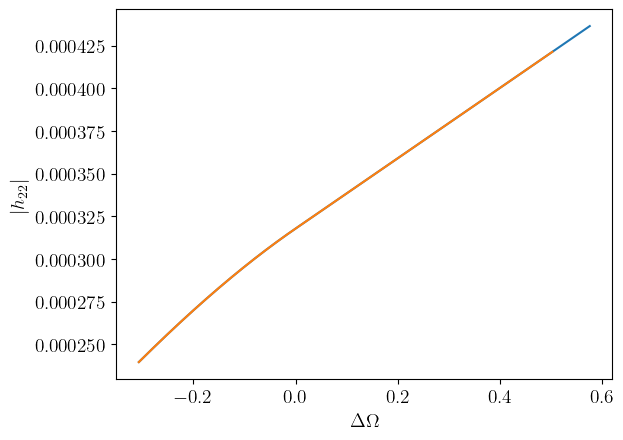

In [100]:
DeltaOmega_cutoff=DeltaOmegafinal(q,massratiotype)-0.006

plt.plot(DeltaOmegacomp2(q,massratiotype,DeltaOmega_cutoff)(tvecdensecomp2full_DeltaOmega(q,massratiotype,DeltaOmega_cutoff)),comp2Ampl8interpfull_DeltaOmega(q,l,m,tvecdensecomp2full_DeltaOmega(q,massratiotype,DeltaOmega_cutoff),massratiotype,DeltaOmega_cutoff))
plt.plot((Omegacomp2(q,massratiotype,Omega_cutoff)(tvecdensecomp2full_Omega(q,massratiotype,Omega_cutoff))-Omegai())/nu(q)**(2/5),comp2Ampl8interpfull_Omega(q,l,m,tvecdensecomp2full_Omega(q,massratiotype,Omega_cutoff),massratiotype,Omega_cutoff))


plt.ylabel('$|h_{22}|$')
plt.xlabel('$\Delta\Omega$')

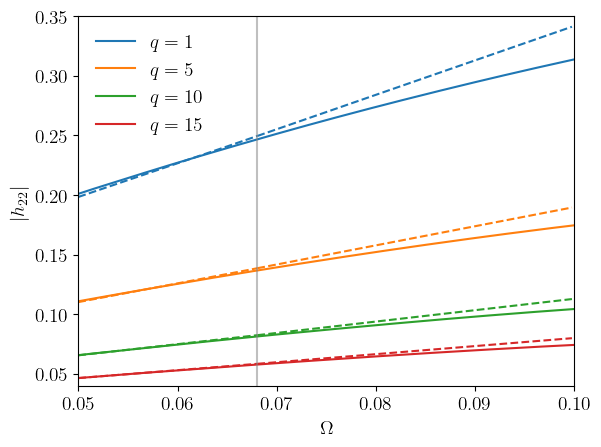

In [240]:
massratiotype=nu

for sim in np.array([19,24,17,34]):
    if sim==19:
        q=1
        colour='C0'
    elif sim==24:
        q=5
        colour='C1'
    elif sim==17:
        q=10
        colour='C2'
    elif sim==34:
        colour='C3'
        q=15

    plt.plot(Omegacomp2(q,massratiotype,Omega_cutoff)(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)),np.abs(comp2AmpLl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(tuple(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)))),ls='--',color=colour)
    plt.plot(Omegacomp2(q,massratiotype,Omega_cutoff)(tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)),np.abs(comp2AmpRl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(tuple(tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)))),'--',color=colour)
    plt.plot(omegaNR_fourthorder_finitediff(sim,N_test,tNR_afterjunk_tohorizon(sim)),ampNRinterp(sim,N_test,tuple(tNR_afterjunk_tohorizon(sim))),color=colour, label='$q=%.0f$'%qNR(sim))

    #plt.plot(omegaNR_fourthorder_finitediff_interp_t(sim,N_test)(np.linspace(tmatchtransition_amp(sim,N_test,10,-10,1e-8),tNR_afterjunk_tohorizon(sim))[maxrange],100),ampNRinterp(sim,N_test,tuple(np.linspace(tmatchtransition_amp(sim,N_test,10,-10,1e-8),tNRnew(sim,N_test)[maxrange],100))),color=colour, label='$q=%.0f$'%qNR(sim))

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.legend(frameon=False)
plt.xlabel('$\Omega$')
plt.ylabel('$|h_{22}|$')
plt.xlim(0.05,0.1)
plt.ylim(0.04,0.35)

plt.savefig('Figures/Amp_Omega_SXSsimsvGSF.png',bbox_inches='tight')

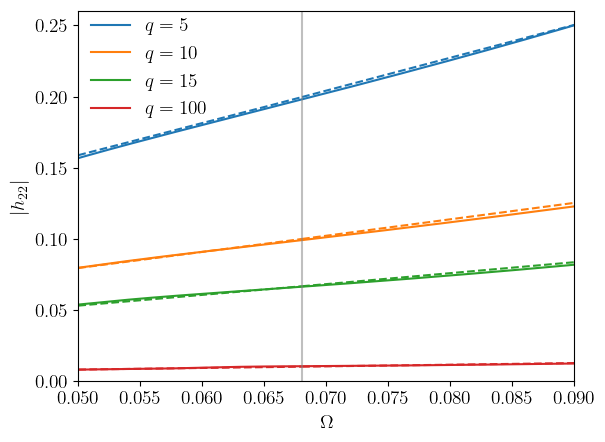

In [254]:
massratiotype=eps

for q in np.array([5,10,15,100]):
    if q==5:
        colour='C0'
    elif q==10:
        colour='C1'
    elif q==15:
        colour='C2'
    elif q==100:
        colour='C3'
        
    plt.plot(Omegacomp2(q,massratiotype,Omega_cutoff)(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)),np.abs(comp2AmpLl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(tuple(tvecdensecomp2L_Omega(q,massratiotype,Omega_cutoff)))),ls='--',color=colour)
    plt.plot(Omegacomp2(q,massratiotype,Omega_cutoff)(tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)),np.abs(comp2AmpRl8interp_Omega(q,l,m,massratiotype,Omega_cutoff)(tuple(tvecdensecomp2R_Omega(q,massratiotype,Omega_cutoff)))),'--',color=colour)
    plt.plot(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),amp_0PA_Omega(q,l,m,omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))),color=colour, label='$q=%.0f$'%q)
    
plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.03),frameon=False)
plt.xlabel('$\Omega$')
plt.ylabel('$|h_{22}|$')

plt.xlim(0.05,0.09)
plt.ylim(0,0.26)

plt.savefig('Figures/Amp_Omega_BHPTNRSurUnCalibratedvGSF.png',bbox_inches='tight')